# Imports

In [1953]:
import pandas as pd
import geopandas as gpd

import numpy as np
from numpy import nan

import os
import sys
import glob
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

from shapely.geometry import Point, LineString
from shapely.ops import unary_union
from pyproj import Proj, transform

import h2o
from h2o.automl import H2OAutoML
h2o.init()

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.api import OLS

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet

from matplotlib import pyplot as plt
plt.style.use('seaborn-talk')

import plotly.express as px 
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output 
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,21 hours 11 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,2 months and 27 days
H2O_cluster_name:,H2O_from_python_manuelfreistein_6k3sz1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.656 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [1954]:
#supress uneccassary warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Loading and Cleaning Data

## Keys

In [1955]:
# Read data from Excel file and drop unnecessary columns
df_keys = pd.read_excel("Data/Schlüssel.xlsx", skiprows=5, dtype=str)
df_keys.columns = ['Bezirk_key1', 'Prognoseraum_key1', 'Bezirksregion_key1', 'Planungsraum', 'Name', 'NaN', 'Bezirk_key2', 'Prognoseraum_key2', 'Bezirksregion_key2']
df_keys = df_keys.drop(columns=['Planungsraum', 'NaN'])

# Clean and merge Bezirks-, Prognoseraum-, and Bezirksregion- numbers into keys

# key_1 can be used on the Kriminalstatistik, Spaetis_Bars_Wettshops datasets
df_keys['Bezirk_key1'] = df_keys['Bezirk_key1'].apply(lambda x: f'0{x}' if len(str(x)) < 2 else str(x))
df_keys['Prognoseraum_key1'] = df_keys['Prognoseraum_key1'].apply(lambda x: f'0{x}' if len(str(x)) < 2 else str(x))
df_keys['Bezirksregion_key1'] = df_keys['Bezirksregion_key1'].apply(lambda x: f'0{x}' if len(str(x)) < 2 else str(x))
df_keys['Prognoseraum_key1'] = df_keys['Prognoseraum_key1'].apply(lambda x: x[1] + x[0] if x[0] == '0' else str(x))
df_keys.drop(df_keys[df_keys['Prognoseraum_key1'].str.contains('nan')].index, inplace=True)
df_keys['key_1'] = df_keys['Bezirk_key1'] + df_keys['Prognoseraum_key1'] + df_keys['Bezirksregion_key1']

# key_2 can be used on Einwohnerregisterstatistik, Straßenbeleuchtung, Wohnlage, and Straßenverkehrsunfälle
df_keys['Bezirk_key2'] = df_keys['Bezirk_key2'].apply(lambda x: f'{int(x):02d}'.split('.')[0])
df_keys['Prognoseraum_key2'] = df_keys['Prognoseraum_key2'].apply(lambda x: f'{int(x):02d}'.split('.')[0])
df_keys['Bezirksregion_key2'] = df_keys['Bezirksregion_key2'].apply(lambda x: f'{int(x):02d}'.split('.')[0])
df_keys['key_2'] = df_keys['Bezirk_key2'] + df_keys['Prognoseraum_key2'] + df_keys['Bezirksregion_key2']

# Remove duplicates to obtain the unique merged Bezirks-, Prognoseraum-, Bezirksregion- keys
df_keys = df_keys[['key_1', 'key_2']].drop_duplicates().reset_index(drop=True)

In [1956]:
#df_keys.head()

In [1957]:
df_keys.to_excel('data/df_keys.xlsx', index=True)

## Kriminalstatistik Fallzahlen 2012-2020

In [1958]:
# Importing and cleaning Berlin crime Fallzahlen 2012-2021 statistics
xls_Kriminalstatistik = pd.ExcelFile("Data/Kriminalstatistik/Fallzahlen&HZ 2012-2021.xlsx")
Kriminalstatistik_Fallzahlen_2012_2021 = []

for year in range(2012, 2022):
    # Read data for current year
    df_Kriminalstatistik = pd.read_excel(xls_Kriminalstatistik, "Fallzahlen_" + str(year), header=None, index_col=None)
    # Remove first 4 and last rows (unnecessary information)
    df_Kriminalstatistik = df_Kriminalstatistik[4:-1]
    # Reset index and rename columns to the first row of the dataframe, drop first row
    df_Kriminalstatistik = df_Kriminalstatistik.reset_index(drop=True).rename(columns=df_Kriminalstatistik.iloc[0])[1:]
    # Remove rows containing "Bezirk", "Berlin", or "0000" in the "Bezeichnung (Bezirksregion)" or "LOR-Schlüssel (Bezirksregion)" columns
    df_Kriminalstatistik = df_Kriminalstatistik[~df_Kriminalstatistik['Bezeichnung (Bezirksregion)'].str.contains("Bezirk|Berlin")]
    df_Kriminalstatistik = df_Kriminalstatistik[~df_Kriminalstatistik['LOR-Schlüssel (Bezirksregion)'].str.contains("0000")]
    # Clean up column names
    df_Kriminalstatistik = df_Kriminalstatistik.rename(columns={"LOR-Schlüssel (Bezirksregion)": "key_1", "Bezeichnung (Bezirksregion)": "Bezirksregion"})
    df_Kriminalstatistik.columns = df_Kriminalstatistik.columns.str.replace('\n', '').str.replace('-', '').str.replace(',', ', ').str.replace(',  ', ', ')
    # change all column values to float except index and Bezirksregion (str)
    ignore = ['Bezirksregion', 'key_1']
    df_Kriminalstatistik = (df_Kriminalstatistik.set_index(ignore, append=True).astype(float).reset_index(ignore))
    # Add 'year' column
    df_Kriminalstatistik['year'] = year
    # Reset index
    df_Kriminalstatistik = df_Kriminalstatistik.reset_index(drop=True)
    Kriminalstatistik_Fallzahlen_2012_2021.append(df_Kriminalstatistik)

In [1959]:
#Kriminalstatistik_Fallzahlen_2012_2021[0].head()
#Kriminalstatistik_Fallzahlen_2012_2021[0].dtypes

## Einwohnerregisterstatistik 2012-2020

In [1960]:
#importing and cleaning Einwohnerregisterstatistik 2012-2020 statistics
df_Einwohnerregisterstatistik_2012_2020 = []

for year in range(2012,2021):
    df_Einwohnerregisterstatistik = pd.read_csv(f"Data/Einwohnerregisterstatistik/EWR{year}12E_Matrix.csv", sep=None, decimal=',', engine='python', encoding='latin1')    
    #rename columns
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.rename(columns={'RAUMID': 'key_2', 'E_E': 'E insgesamt', 'E_EM': 'männlich', 'E_EW': 'weiblich'})
    #sum columns to get age groups
    age_groups = {'E_U1': ['E_E00_01'], 'E_1U6': ['E_E01_02', 'E_E02_03', 'E_E03_05', 'E_E05_06'],
                  'E_6U15': ['E_E06_07', 'E_E07_08', 'E_E08_10', 'E_E10_12', 'E_E12_14', 'E_E14_15'],
                  'E_15U18': ['E_E15_18'], 'E_18U25': ['E_E18_21', 'E_E21_25'], 
                  'E_25U35': ['E_E25_27', 'E_E27_30', 'E_E30_35'], 'E_35U45': ['E_E35_40', 'E_E40_45'],
                  'E_45U55': ['E_E45_50', 'E_E50_55'], 'E_55U65': ['E_E55_60', 'E_E60_63', 'E_E63_65'], 
                  'E_65U80': ['E_E65_67', 'E_E67_70', 'E_E70_75', 'E_E75_80'],
                  'E_80U110': ['E_E80_85', 'E_E85_90', 'E_E90_95', 'E_E95_110']}
    for key,value in age_groups.items():
        df_Einwohnerregisterstatistik[key]= df_Einwohnerregisterstatistik[value].sum(axis=1)
    #drop unneccessary columns and transform remaining columns to integers except key_2
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.reindex(columns=['key_2', 'E insgesamt', 'weiblich', 'männlich', 'E_U1', 'E_1U6', 'E_6U15', 'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110'])
    ignore = ['key_2']
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.set_index(ignore, append=True).astype(int).reset_index(ignore)
    #transform RAUMID key to key_2 format
    df_Einwohnerregisterstatistik['key_2'] = df_Einwohnerregisterstatistik['key_2'].astype(str).apply(lambda x: "0" + x[:len(x)-2] if len(x) < 8 else x[:len(x)-2])
    df_Einwohnerregisterstatistik = df_Einwohnerregisterstatistik.groupby('key_2').sum().reset_index()
    #add 'year' column
    df_Einwohnerregisterstatistik["year"] = year
    df_Einwohnerregisterstatistik_2012_2020.append(df_Einwohnerregisterstatistik)

In [1961]:
#df_Einwohnerregisterstatistik_2012_2020[1].head()

## Spaetis Bars and Wettshops 2016-2019

In [1962]:
# Importing Berlin Spaetis_Bars_Wettshops 2016-2019 statistics
df_Spaetis_Bars_Wettshops_2016_2019 = pd.read_excel("Data/Spaetis_Bars_Wettshops/Spaetis_Bars_Wettshops_2016-2019.xlsx", header=None, index_col=1)

# General cleanup
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019[9:]
df_Spaetis_Bars_Wettshops_2016_2019['Bezirksregion'] = df_Spaetis_Bars_Wettshops_2016_2019.index
df_Spaetis_Bars_Wettshops_2016_2019.index = range(1, len(df_Spaetis_Bars_Wettshops_2016_2019) + 1)
df_Spaetis_Bars_Wettshops_2016_2019.columns = ['NaN', 'Ausschank von Getränken (2019)', 'Spiel-, Wett- und Lotteriewesen (2019)', 'Einzelhandel mit Getränken (2019)', 'Einzelhandel mit Tabakwaren (2019)',
                                               'Ausschank von Getränken (2016)', 'Spiel-, Wett- und Lotteriewesen (2016)', 'Einzelhandel mit Getränken (2016)', 'Einzelhandel mit Tabakwaren (2016)',
                                               'Ausschank von Getränken (2017)', 'Spiel-, Wett- und Lotteriewesen (2017)', 'Einzelhandel mit Getränken (2017)', 'Einzelhandel mit Tabakwaren (2017)',
                                               'Ausschank von Getränken (2018)', 'Spiel-, Wett- und Lotteriewesen (2018)', 'Einzelhandel mit Getränken (2018)', 'Einzelhandel mit Tabakwaren (2018)', 'Bezirksregion']
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.drop('NaN', axis=1).drop([1, 3, 4])
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.reset_index(drop=True)[:150].drop(0, axis=0)
# Extract the first part of Bezirksregion as key_1
df_Spaetis_Bars_Wettshops_2016_2019["key_1"] = df_Spaetis_Bars_Wettshops_2016_2019["Bezirksregion"].str.split().str[0]
# Replace all "-" values in table with 0 
df_Spaetis_Bars_Wettshops_2016_2019 = df_Spaetis_Bars_Wettshops_2016_2019.replace('-',0)

# Separate the data into dataframes for each year and store them in a list
df_Spaetis_Bars_Wettshops = []
for year in range(2016, 2020):
    column_names = [f"{category} ({year})" for category in ['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen', 'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren']]
    df_year = df_Spaetis_Bars_Wettshops_2016_2019[column_names + ['key_1']].copy()
    df_year.columns = [c.replace(f" ({year})", "") for c in df_year.columns]
    df_year['year'] = year
    df_Spaetis_Bars_Wettshops.append(df_year)

In [1963]:
#df_Spaetis_Bars_Wettshops[0].head()

## Bezirksregionen spatial data

In [1964]:
#importing Berlin LOR spatial data
LOR_gpd = gpd.read_file("./Data/LOR/lor_shp_2019/Bezirksregion_EPSG_25833.shp")
LOR_gpd.crs = "epsg:25833"
LOR_gpd = LOR_gpd.to_crs(epsg=4326)

#compute area for each Bezirk in km squared
LOR_gpd['area'] = LOR_gpd['geometry'].to_crs({'init': 'epsg:32633'}).map(lambda p: p.area / 10**6)

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



In [1965]:
#LOR_gpd['area'].sum(axis = 0, skipna = True)
#LOR_gpd.dtypes

In [1966]:
#LOR_gpd.head()

In [1967]:
#LOR_gpd.plot()

## Öffentliche Beleuchtung

In [1968]:
# Import and concatenate Öffentliche_Beleuchtung data
path_Oeffentliche_Beleuchtung = glob.glob('./Data/Öffentliche_Beleuchtung/*.xls')
Oeffentliche_Beleuchtung = pd.concat([pd.read_excel(path) for path in path_Oeffentliche_Beleuchtung])

# Create a GeoDataFrame with latitude and longitude coordinates
geometry = [Point(xy) for xy in zip(Oeffentliche_Beleuchtung['East'], Oeffentliche_Beleuchtung['North'])]
crs = {'init': 'epsg:25833'}
Oeffentliche_Beleuchtung_gpd = gpd.GeoDataFrame(Oeffentliche_Beleuchtung, crs=crs, geometry=geometry).to_crs(epsg=4326)

# Spatial join with LOR shapefile
Beleuchtung_LOR = gpd.sjoin(Oeffentliche_Beleuchtung_gpd, LOR_gpd, how='left')

# Group and summarize data
Beleuchtung_LOR = Beleuchtung_LOR[['SCHLUESSEL', 'area']]
Beleuchtung_LOR['num_street_lights'] = Beleuchtung_LOR.groupby('SCHLUESSEL')['SCHLUESSEL'].transform('count')
Beleuchtung_LOR = Beleuchtung_LOR.rename(columns={'SCHLUESSEL': 'key_2'})
Beleuchtung_LOR = Beleuchtung_LOR.drop_duplicates(subset='key_2', keep='first', inplace=False).dropna(inplace=False)
Beleuchtung_LOR = Beleuchtung_LOR.astype({"key_2": str, "num_street_lights": int}).reset_index(drop=True)

In [1969]:
#Beleuchtung_LOR.head()

## Wohnlage 2012-2020

In [1970]:
#importing Berlin Wohnlage 2012-2020 statistics
Wohnlage_2012_2020 = []

for year in range(2012,2021):
    df_Wohnlage = pd.read_csv(f'Data/Wohnlage/WHNLAGE{str(year)}_Matrix.csv', sep=None, engine='python')
    #transform RAUMID to key_2 format
    df_Wohnlage = pd.DataFrame(df_Wohnlage.rename(columns={'RAUMID': 'key_2'}).astype({"key_2": str}))
    df_Wohnlage["key_2"] = df_Wohnlage["key_2"].apply(lambda x: "0"+ x[:len(x)-2] if len(x)<8 else x[:len(x)-2])
    #Group by key_2
    df_Wohnlage = df_Wohnlage.groupby('key_2').sum().reset_index()
    #add 'year' column
    df_Wohnlage['year'] = year
    
    #combine "mit Lärm" and "ohne Lärm" for each Bezirksregion
    df_Wohnlage['WLEINF'] = df_Wohnlage['WLEINFoL'] + df_Wohnlage['WLEINFmL']
    df_Wohnlage['WLMIT'] = df_Wohnlage['WLMIToL'] + df_Wohnlage['WLMITmL']
    df_Wohnlage['WLGUT'] = df_Wohnlage['WLGUToL'] + df_Wohnlage['WLGUTmL']
    df_Wohnlage = df_Wohnlage[["key_2", "year", "WLEINF", "WLMIT", "WLGUT", "WLNZORD" ]]
    
    Wohnlage_2012_2020.append(df_Wohnlage)

In [1971]:
#Wohnlage_2012_2020[0].head()

## __Straßenverkehrsunfälle 2018-2020__

In [1972]:
#importing Berlin Straßenverkehrsunfälle 2018-2021 statistics
Straßenverkehrsunfaelle_2018_2020 = []

for year in range(2018,2021):
    df_Straßenverkehrsunfaelle = pd.read_csv(f"Data/Straßenverkehrsunfälle/AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_{str(year)}_Datensatz.csv", sep=None, engine='python', encoding='latin-1')
    
    #transform LOR to key_2 format
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.rename(columns={'LOR': 'key_2'}).astype({"key_2": str})
    df_Straßenverkehrsunfaelle["key_2"] = df_Straßenverkehrsunfaelle["key_2"].apply(lambda x: x[:len(x)-4] if '.' in x else x[:len(x)-2]).apply(lambda x: "0"+x if len(x)<6 else x)

    #count number of different accidents that occured in each Bezirksregion                                 
    categories = {1: 'Unfall mit Getöteten', 2: 'Unfall mit Schwerverletzten', 3: 'Unfall mit Leichtverletzten'}
    for category, name in categories.items():
        temp = df_Straßenverkehrsunfaelle.groupby('key_2')['UKATEGORIE'].apply(lambda x: (x==category).sum()).reset_index(name=name)
        df_Straßenverkehrsunfaelle = pd.merge(df_Straßenverkehrsunfaelle, temp, how='outer', on=['key_2'])
    
    #remove unecessary rows and columns and add year column
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle[["key_2", "Unfall mit Getöteten", "Unfall mit Schwerverletzten", "Unfall mit Leichtverletzten"]]
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.drop_duplicates(subset='key_2', keep='first', inplace=False)[df_Straßenverkehrsunfaelle["key_2"] != "0n"]
    df_Straßenverkehrsunfaelle = df_Straßenverkehrsunfaelle.sort_values(by=['key_2']).reset_index(drop=True)
    df_Straßenverkehrsunfaelle['year'] = year

    Straßenverkehrsunfaelle_2018_2020.append(df_Straßenverkehrsunfaelle)

In [1973]:
#Straßenverkehrsunfaelle_2018_2020[0].head()

# Imputing Missing Data

## Öffentlich Beleuchtung

In [1974]:
#Unfortunately, I was only able to acquire streetlight data for a single year
#But, we can assume that the number of streetlights hasn't change much over the past decade
#The data we currently have will therefore be copied for each year
Öffentliche_Beleuchtung_2012_2020 = []

for year in range(2012,2021):
    Beleuchtung_year = Beleuchtung_LOR.copy()
    Beleuchtung_year['year'] = year
    Beleuchtung_year = Beleuchtung_year.sort_values('key_2').reset_index(drop=True)
    Öffentliche_Beleuchtung_2012_2020.append(Beleuchtung_year)

In [1976]:
#Öffentliche_Beleuchtung_2012_2020[0].head()

## Straßenverkehrsunfaelle 2012-2017

In [1977]:
#The Straßenverkehrsunfälle dataset is missing values for years 2012-2017. Simple Linear Regression was calculated
#and used to predict the missing values for each Bezirksregion individually. If I had the time, I would research time
#series data imputation methods in order to come up with a more sophisticated approach than simple linear regression.

# Merge Straßenverkehrsunfaelle data for each year
Straßenverkehrsunfaelle_imputation = pd.concat(Straßenverkehrsunfaelle_2018_2020).reset_index(drop=True)

# Create new dataframe for predictions (2012-2017)
Straßenverkehrsunfaelle_pred = pd.DataFrame(columns=['key_2', 'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten', 'year'])

# For each Bezirksregion all three Unfallarten were predicted for years 2012-2017
for Bezirksregion, group in Straßenverkehrsunfaelle_imputation.groupby('key_2'):
    temp = pd.DataFrame({'year': range(2012, 2018)})
    temp['key_2'] = Bezirksregion
    for Unfallart in ['Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten']:
        X = np.array(group['year']).reshape((-1, 1))
        y = np.array(group[Unfallart])
        model = LinearRegression()
        model.fit(X, y)
        #linear regression predicted negative values, which were removed and replaced with 0
        y_predict = np.maximum(model.predict(temp[['year']]), 0)
        temp[Unfallart] = y_predict.astype(int)
    Straßenverkehrsunfaelle_pred = Straßenverkehrsunfaelle_pred.append(temp)

# Predictions were added to given data and everything was sorted by Bezirksregion and year
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.append(Straßenverkehrsunfaelle_pred)
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.set_index(['key_2'], append=True).astype(int).reset_index(['key_2'])
Straßenverkehrsunfaelle_imputation = Straßenverkehrsunfaelle_imputation.sort_values(['key_2', 'year']).reset_index(drop=True)

In [1978]:
#Straßenverkehrsunfaelle_imputation.head()

## Spaetis Bars and Wettshops 2012-2015 and 2020

In [1979]:
# Merge Straßenverkehrsunfaelle data for each year
Spaetis_Bars_Wettshops_imputation = pd.concat(df_Spaetis_Bars_Wettshops).reset_index(drop=True)

# Create new dataframe for predictions (2012-2015 and 2020)
shops = ['Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen', 'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren']
Spaetis_Bars_Wettshops_pred = pd.DataFrame(columns=['key_1', 'year']+shops)

# For each Bezirksregion all types of shops were predicted for years 2012-2015 and 2020
for Bezirksregion, group in Spaetis_Bars_Wettshops_imputation.groupby('key_1'):
    temp = pd.DataFrame({'year': [2012,2013,2014,2015,2020]})
    temp['key_1'] = Bezirksregion
    for shop in shops:
        X = np.array(group['year']).reshape((-1, 1))
        y = np.array(group[shop])
        model = LinearRegression()
        model.fit(X, y)
        #linear regression predicted negative values, which were removed and replaced with 0
        y_predict = np.maximum(model.predict(temp[['year']]), 0)
        temp[shop] = y_predict.astype(int)
    Spaetis_Bars_Wettshops_pred = Spaetis_Bars_Wettshops_pred.append(temp)

# Predictions were added to given data and everything was sorted by Bezirksregion and year
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.append(Spaetis_Bars_Wettshops_pred)
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.set_index(['key_1'], append=True).astype(int).reset_index(['key_1'])
Spaetis_Bars_Wettshops_imputation = Spaetis_Bars_Wettshops_imputation.sort_values(['key_1', 'year']).reset_index(drop=True)

In [1980]:
#Spaetis_Bars_Wettshops_imputation.head()

# Merging Data

In [1981]:
def translate_variables(df):
    df = df.rename(columns = {"E insgesamt": "Total Population",
                                        "weiblich": "Female Population",
                                        "männlich": "Male Population",
                                        "E_U1": "Population  Infants",
                                        "E_1U6": "Population ages 1-6",
                                        "E_6U15": "Population ages 6-15",
                                        "E_15U18": "Population ages 15-18",
                                        "E_18U25": "Population ages 18-25",
                                        "E_25U35": "Population ages 25-35",
                                        "E_35U45": "Population ages 35-45",
                                        "E_45U55": "Population ages 45-55",
                                        "E_55U65": "Population ages 55-65",
                                        "E_65U80": "Population ages 65-80",
                                        "E_80U110": "Population ages 80-110",
                                        "WLEINF": "Simple residential area",
                                        "WLMIT": "Average residential area",
                                        "WLGUT": "Good residential area",
                                        "WLNZORD": "Residential area without allocation",
                                        "area": "Area in square kilometers",
                                        "num_street_lights": "Number of street lights",
                                        "Einzelhandel mit Tabakwaren" : "Tobacco retail dealers",
                                        "Einzelhandel mit Getränken" : "Liquor stores",
                                        "Ausschank von Getränken" : "Bars, pubs and clubs",
                                        "Spiel-, Wett- und Lotteriewesen" : "Casinos and betting stores",
                                        "Unfall mit Leichtverletzten": "Accidents with minor injuries",
                                        "Unfall mit Schwerverletzten": "Accidents with major injuries",
                                        "Unfall mit Getöteten": "Accidents resulting in deaths",})
    return df

In [1982]:
# Merge datasets on key_1
df_merged_data_key_1 = pd.concat([Kriminalstatistik_Fallzahlen_2012_2021[i] for i in range(len(Kriminalstatistik_Fallzahlen_2012_2021))])
df_merged_data_key_1 = pd.merge(df_merged_data_key_1, Spaetis_Bars_Wettshops_imputation, on=['key_1', 'year'])
df_merged_data_key_1 = df_merged_data_key_1.sort_values(['key_1', 'year'])

In [1983]:
# Merge datasets on key_2
df_merged_data_key_2 = pd.concat([df_Einwohnerregisterstatistik_2012_2020[i] for i in range(len(df_Einwohnerregisterstatistik_2012_2020))])
df_Wohnlage_2012_2020_all = pd.concat([Wohnlage_2012_2020[i] for i in range(len(Wohnlage_2012_2020))])
Öffentliche_Beleuchtung_2012_2020_all = pd.concat([Öffentliche_Beleuchtung_2012_2020[i] for i in range(len(Öffentliche_Beleuchtung_2012_2020))])

df_merged_data_key_2 = df_merged_data_key_2.merge(df_Wohnlage_2012_2020_all, on=['key_2', 'year'])
df_merged_data_key_2 = df_merged_data_key_2.merge(Öffentliche_Beleuchtung_2012_2020_all, on=['key_2', 'year'])
df_merged_data_key_2 = df_merged_data_key_2.merge(Straßenverkehrsunfaelle_imputation, on=['key_2', 'year'])
df_merged_data_key_2 = df_merged_data_key_2.merge(df_keys, on=['key_2'])
df_merged_data_key_2 = df_merged_data_key_2.sort_values(['key_2', 'year']).reset_index(drop=True)

In [1984]:
# merge key_1 and key_2 datasets
df_merged_data = pd.merge(df_merged_data_key_1, df_merged_data_key_2, on=['key_1', 'year'])
df_merged_data = df_merged_data.set_index(['key_1', 'key_2', 'Bezirksregion', 'year'], drop=True)

#due to discrepancies between key_1 and key_2, some key_2 areas in Charlottenburg-Wilmersdorf and 
#Tempelhof-Schöneberg need to be summed up and grouped under key_1
df_merged_data = df_merged_data.groupby(['key_1', 'year', 'Bezirksregion']).sum()

# convert all column values to floats
df_merged_data = df_merged_data._convert(numeric=True)
df_merged_data = df_merged_data.astype(float)

In [1985]:
#df_merged_data.head()

In [1986]:
# variables are translated into english for the dashboard
# As legal terms are not directly translatable, the types of crime will remain in German
df_merged_data = translate_variables(df_merged_data)

In [1987]:
df_merged_data.to_excel('data/df_merged.xlsx', index=True)

In [1988]:
#divide values by total population of each Bezirksregion
variables = df_merged_data.columns.tolist()
variables.remove('Total Population')
df_by_population = df_merged_data[variables].div(df_merged_data['Total Population'], axis=0)

In [1989]:
df_by_population.to_excel('data/df_by_population.xlsx', index=True)

In [1990]:
#divide values by area of each Bezirksregion
variables = df_merged_data.columns.tolist()
variables.remove('Area in square kilometers')
df_by_area = df_merged_data[variables].div(df_merged_data['Area in square kilometers'], axis=0)

In [1991]:
df_by_area.to_excel('data/df_by_area.xlsx', index=True)

# Machine Learning

In [1992]:
#Function to add zeros from the beginning of key_1. They are removed automatically while loading from excel file
def add_zeros_key_1(df):
    df = df.reset_index(inplace=False)
    df["key_1"] = df["key_1"].apply(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
    #reset the multi index
    df.set_index(['key_1', 'year', 'Bezirksregion'], inplace=True, drop=True)
    return df

In [1993]:
def create_target_and_variable_df(target, df, df_type='merged'):
    variables = df.columns.tolist()[17:]+[target]
    if df_type == 'by_area':
        variables.remove("area")
    if df_type == 'by_population':
        variables.remove("E insgesamt")
    df = df[variables]
    return df

In [1994]:
def scale_data_by_Bezirksregion(df):
    # create a copy of the original dataframe
    df_RF = df.copy()
    #Each Population stastics is divided by total population of each Bezirksregion
    columns_to_process = ['weiblich', 'E_U1', 'E_1U6', 'E_6U15', 'E_15U18', 'E_18U25', 'E_25U35', 'E_35U45', 'E_45U55', 'E_55U65', 'E_65U80', 'E_80U110', 'Unfall mit Leichtverletzten', 'Unfall mit Schwerverletzten', 'Unfall mit Getöteten']
    for column in columns_to_process:
        df_RF[f'{column} per pop'] = df[column].div(df['E insgesamt'])
        df_RF = df_RF.drop([column], axis=1)
    #Each area stastics is divided by total area of each Bezirksregion
    columns_to_process = ['E insgesamt', 'Ausschank von Getränken', 'Spiel-, Wett- und Lotteriewesen', 'Einzelhandel mit Getränken', 'Einzelhandel mit Tabakwaren', 'num_street_lights', 'WLEINF', 'WLMIT', 'WLGUT', 'WLNZORD']
    for column in columns_to_process:
        df_RF[f'{column} per km²'] = df[column].div(df['area'])  
        df_RF = df_RF.drop([column], axis=1)
    #male population statistic is removed due to high correlation with female population
    df_RF = df_RF.drop(['männlich'], axis=1)
    #area statistic is removed due to high correlation with 'total population per km²'
    df_RF = df_RF.drop(['area'], axis=1)
    return df_RF

## Multiple Linear Regression

In [1995]:
#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

#choose target and add to variable dataframe
#optional: pass 'by_area' or 'by_population' as third parameter if if working with df_by_area or df_by_population dataframes
target = 'Straftaten insgesamt'
df = create_target_and_variable_df(target, df)

#optional: prepare data to get more accurate results. Divides variables by individual Bezirksregion's population or area in sqkm
#df = scale_data_by_Bezirksregion(df)

In [1996]:
scaled_data = StandardScaler().fit_transform(df.copy())
X = pd.DataFrame(scaled_data,columns=[df.columns.tolist()])
y = X.pop(target)

In [1997]:
OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Straftaten insgesamt   R-squared (uncentered):                   0.864
Model:                              OLS   Adj. R-squared (uncentered):              0.861
Method:                   Least Squares   F-statistic:                              320.9
Date:                  Mon, 20 Feb 2023   Prob (F-statistic):                        0.00
Time:                          09:50:56   Log-Likelihood:                         -541.91
No. Observations:                  1287   AIC:                                      1134.
Df Residuals:                      1262   BIC:                                      1263.
Df Model:                            25                                                  
Covariance Type:              nonrobust                                                  
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Bars, pubs and clubs                    0.3089      0.027     11.568      0.000       0.256       0.361
Casinos and betting stores              0.2034      0.017     11.685      0.000       0.169       0.237
Liquor stores                           0.0838      0.020      4.268      0.000       0.045       0.122
Tobacco retail dealers                  0.1834      0.017     10.948      0.000       0.151       0.216
Total Population                        2.1470     28.955      0.074      0.941     -54.659      58.953
Female Population                       1.1990     29.381      0.041      0.967     -56.442      58.840
Male Population                         3.1179     28.369      0.110      0.913     -52.538      58.774
Population  Infants                     0.0687      1.773      0.039      0.969      -3.411       3.548
Population ages 1-6                     1.0766      8.536      0.126      0.900     -15.670      17.823
Population ages 6-15                    1.0815     13.364      0.081      0.936     -25.136      27.299
Population ages 15-18                  -0.1183      4.504     -0.026      0.979      -8.955       8.718
Population ages 18-25                   1.2417     15.029      0.083      0.934     -28.243      30.726
Population ages 25-35                   2.8209     37.948      0.074      0.941     -71.628      77.270
Population ages 35-45                   1.7098     28.370      0.060      0.952     -53.948      57.368
Population ages 45-55                   1.8852     27.939      0.067      0.946     -52.926      56.697
Population ages 55-65                   1.7725     25.631      0.069      0.945     -48.512      52.057
Population ages 65-80                   2.8442     31.651      0.090      0.928     -59.250      64.939
Population ages 80-110                  0.7376     11.270      0.065      0.948     -21.372      22.847
Simple residential area               -15.3320    206.739     -0.074      0.941    -420.923     390.259
Average residential area              -14.4362    195.117     -0.074      0.941    -397.226     368.353
Good residential area                 -15.2295    208.924     -0.073      0.942    -425.105     394.646
Residential area without allocation    -0.1131      1.880     -0.060      0.952      -3.802       3.576
Area in square kilometers              -0.0343      0.014     -2.523      0.012      -0.061      -0.008
Number of street lights                -0.0011      0.021     -0.051      0.959      -0.042       0.040
Accidents resulting in deaths          -0.0206      0.011     -1.882      0.060      -0.042       0.001
Accidents with major injuries           0.0030    

## Random Forest Regression

In [1998]:
#Random Forest models give us feature importance, which goes a long way in understanding crime

#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

In [1999]:
df_feature_importances = pd.DataFrame(index=Straftaten, columns=variables)

Straftaten = df.columns.tolist()[:17]
variables = df.columns.tolist()[17:]

for Straftat in Straftaten:
    # Preparing dataframe for each type of crime
    dff = df[variables + [Straftat]].copy()

    # Train-test split
    dff_train, dff_test = train_test_split(dff, test_size=0.2, random_state=0)

    # Split data into data (X) and target (y) and transform to numpy array
    X_train = dff_train.iloc[:, :-1].values
    y_train = dff_train.iloc[:, -1].values
    X_test = dff_test.iloc[:, :-1].values
    y_test = dff_test.iloc[:, -1].values

    # Scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply random forest model to data
    model = RandomForestRegressor(n_estimators=100, random_state=0, criterion='absolute_error', max_depth=None)
    model.fit(X_train, y_train)

    # Get predictions as well as error scores MAE and MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Save feature importances to dataframe
    feature_imp = pd.Series(model.feature_importances_, index=variables).sort_values(ascending=False)
    df_feature_importances.loc[Straftat, feature_imp.index] = feature_imp.values

    # Print results
    print("**********************************************************************************")
    print(Straftat)
    print("Mean squared error using Random Forest targeting '" + Straftat + "': " + str(mse))
    print("Mean absolute error using Random Forest targeting '" + Straftat + "': " + str(mae))
    print("Mean number of '" + Straftat + "' crimes: " + str(dff[Straftat].mean()))
    print("Largest number of '" + Straftat + "' crimes: " + str(dff[Straftat].max()))
    print("Smallest number of '" + Straftat + "' crimes: " + str(dff[Straftat].min()))
    print("Feature Importance:")
    print(feature_imp.head(5))
    print("**********************************************************************************")

**********************************************************************************
Straftaten insgesamt
Mean squared error using Random Forest targeting 'Straftaten insgesamt': 1348600.8527217056
Mean absolute error using Random Forest targeting 'Straftaten insgesamt': 547.6764728682172
Mean number of 'Straftaten insgesamt' crimes: 3785.063714063714
Largest number of 'Straftaten insgesamt' crimes: 49120
Smallest number of 'Straftaten insgesamt' crimes: 184
Feature Importance:
Bars, pubs and clubs             0.232912
Accidents with minor injuries    0.152366
Tobacco retail dealers           0.069745
Population ages 25-35            0.066277
Casinos and betting stores       0.057381
dtype: float64
**********************************************************************************
**********************************************************************************
Raub
Mean squared error using Random Forest targeting 'Raub': 229.09061889534885
Mean absolute error using Random Forest targeti

**********************************************************************************
Branddelikte insgesamt
Mean squared error using Random Forest targeting 'Branddelikte insgesamt': 58.746165213178294
Mean absolute error using Random Forest targeting 'Branddelikte insgesamt': 5.2547868217054265
Mean number of 'Branddelikte insgesamt' crimes: 17.86790986790987
Largest number of 'Branddelikte insgesamt' crimes: 160
Smallest number of 'Branddelikte insgesamt' crimes: 0
Feature Importance:
Population ages 18-25         0.129064
Casinos and betting stores    0.108254
Bars, pubs and clubs          0.092258
Population ages 1-6           0.048301
Population  Infants           0.044919
dtype: float64
**********************************************************************************
**********************************************************************************
Brandstiftung
Mean squared error using Random Forest targeting 'Brandstiftung': 26.09332906976744
Mean absolute error using Random For

In [2000]:
#df_RF_feature_importances.head()

In [2001]:
df_RF_feature_importances.to_excel('data/df_RF_feature_importances.xlsx', index=True)

## H2O Auto Machine Learning

### Broad h2O AutoML model search

In [2002]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,21 hours 16 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,2 months and 27 days
H2O_cluster_name:,H2O_from_python_manuelfreistein_6k3sz1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.656 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2003]:
#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

#choose target and add to variable dataframe
#optional: pass 'by_area' or 'by_population' as third parameter if if working with df_by_area or df_by_population dataframes
target = 'Fahrraddiebstahl'
df = create_target_and_variable_df(target, df)

In [2004]:
#convert pandas dataframe to H2O dataframe
hf = h2o.H2OFrame(df)

#split into train and test sets
splits = hf.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [2005]:
#train the AutoML model
aml = H2OAutoML(max_models=5, seed=1)
aml.train(y = target, training_frame = train, leaderboard_frame = test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,45.514694,8.272325,47.775356,44.19612,44.555084,33.991867,57.05505
mean_residual_deviance,6436.5625,3585.872,6760.1826,4475.2007,6248.6587,2565.0134,12133.758
mse,6436.5625,3585.872,6760.1826,4475.2007,6248.6587,2565.0134,12133.758
null_deviance,20132642.0000000,7699114.5,16185111.0000000,21584032.0000000,22333890.0000000,9923280.0,30636896.0000000
r2,0.9349738,0.0189113,0.9117245,0.9578972,0.9420734,0.9436533,0.9195206
residual_deviance,1313936.1,713988.9,1419638.4,903990.5,1293472.2,525827.75,2426751.8
rmse,77.79301,21.932024,82.22033,66.89694,79.048454,50.64596,110.15334
rmsle,0.3277342,0.0421716,0.3900149,nan,0.3067552,0.3161222,0.2980444


In [2006]:
#the leaderboard shows that tree models score high on the dataset
aml.leaderboard.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20230220_95452,52.6378,2770.74,34.517,nan,2770.74
StackedEnsemble_AllModels_1_AutoML_1_20230220_95452,52.7825,2785.99,34.7758,nan,2785.99
DRF_1_AutoML_1_20230220_95452,55.9228,3127.36,35.7919,0.296326,3127.36
XGBoost_2_AutoML_1_20230220_95452,61.9085,3832.67,41.4563,nan,3832.67
XGBoost_1_AutoML_1_20230220_95452,67.6505,4576.58,41.7099,nan,4576.58
GBM_1_AutoML_1_20230220_95452,100.332,10066.5,54.0518,0.477784,10066.5
GLM_1_AutoML_1_20230220_95452,141.672,20071,82.485,nan,20071


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

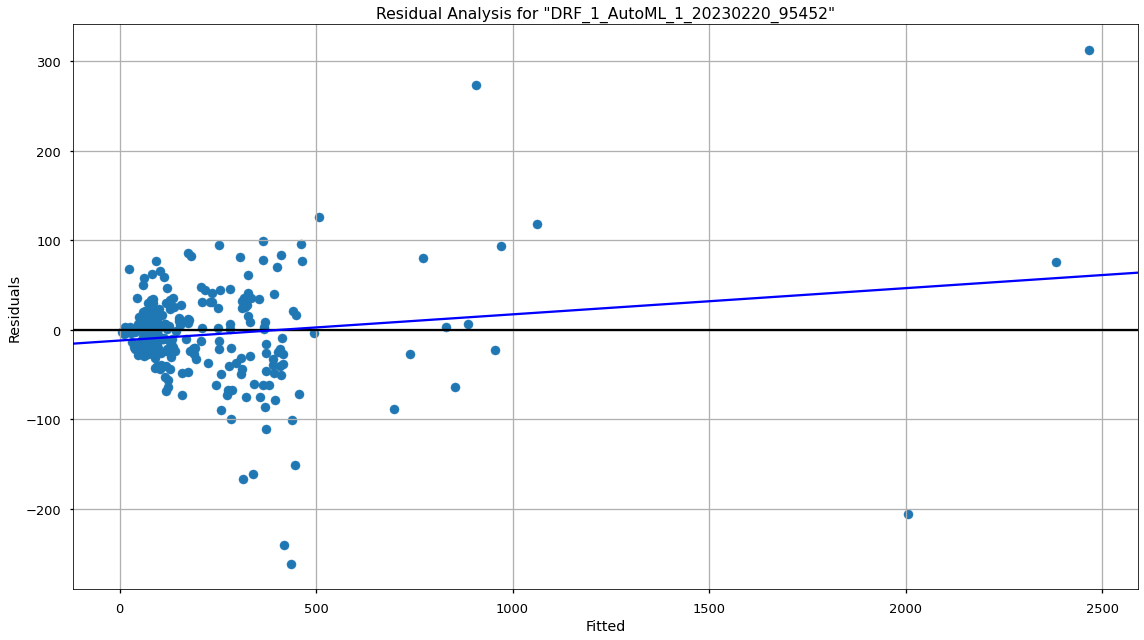

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

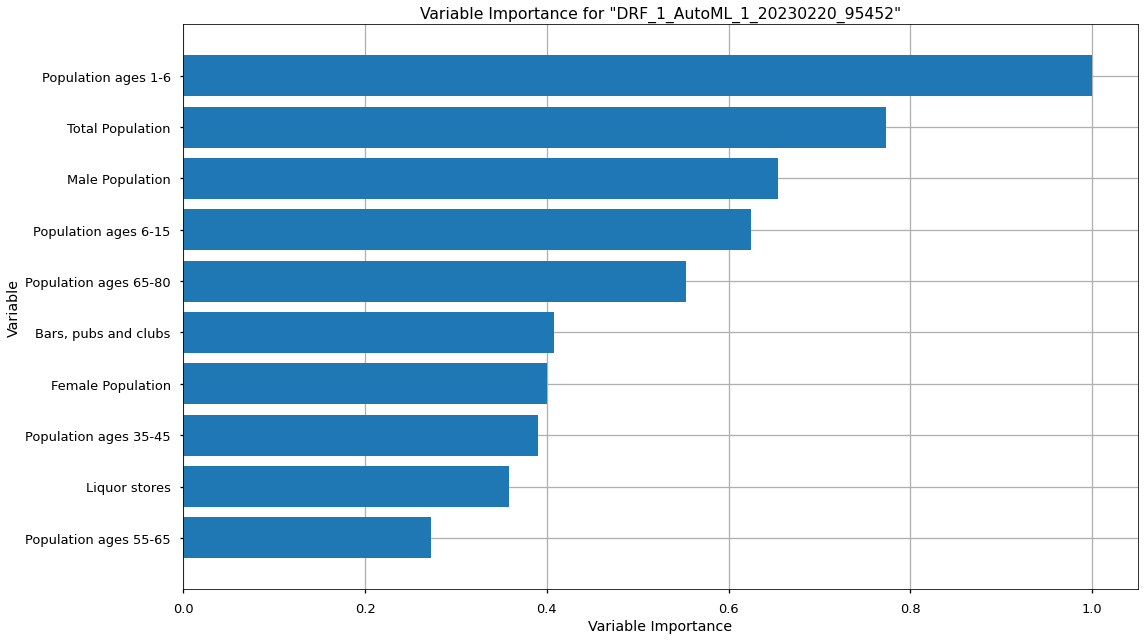

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

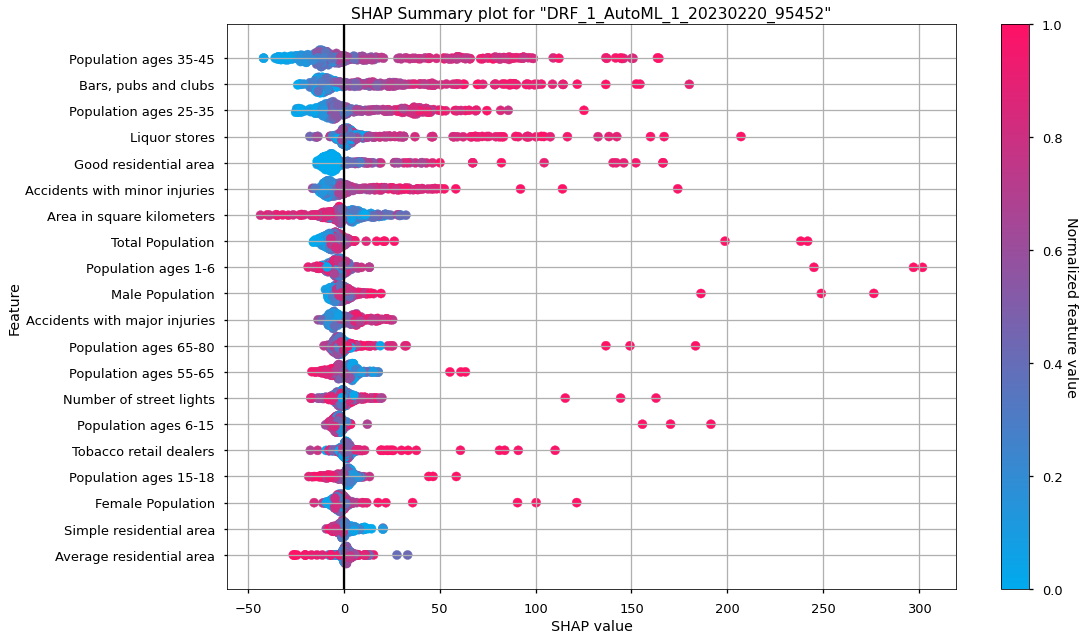

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

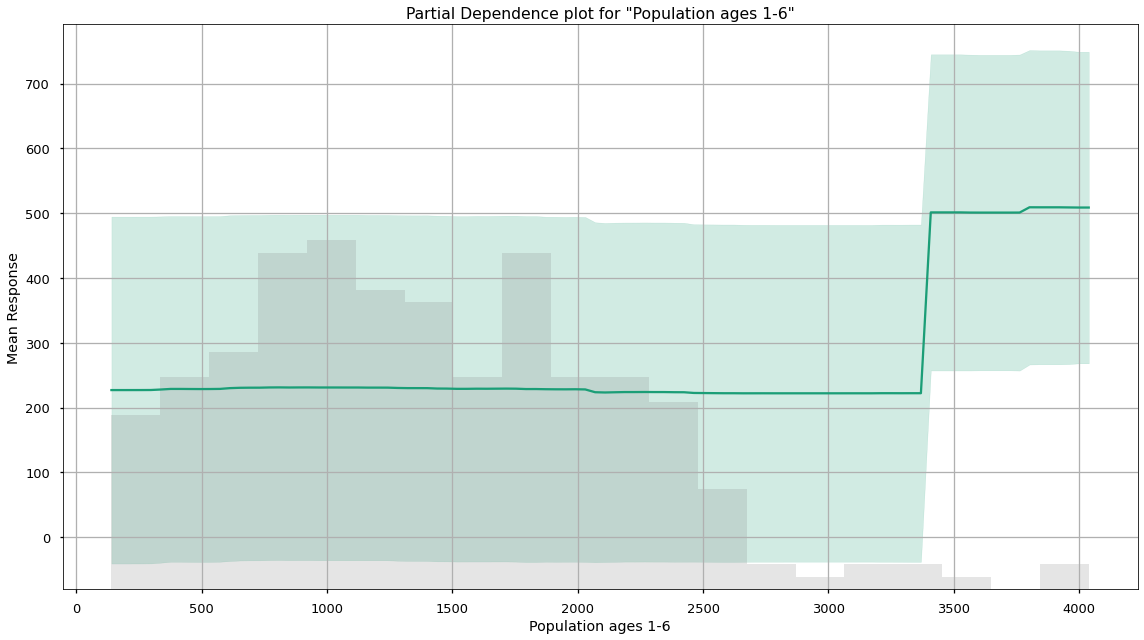

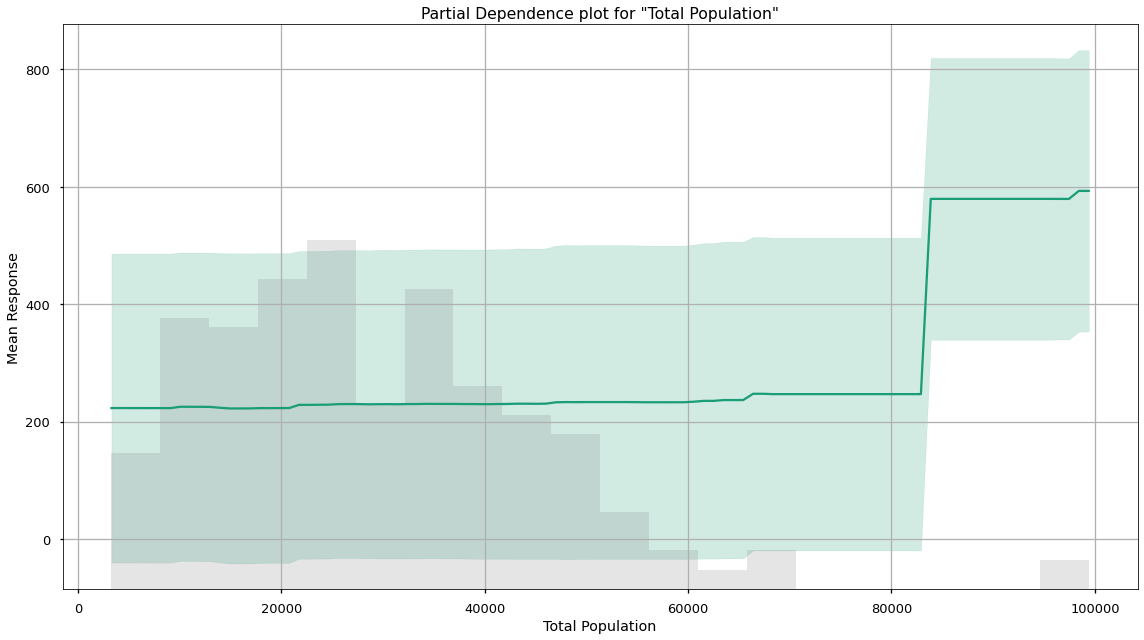

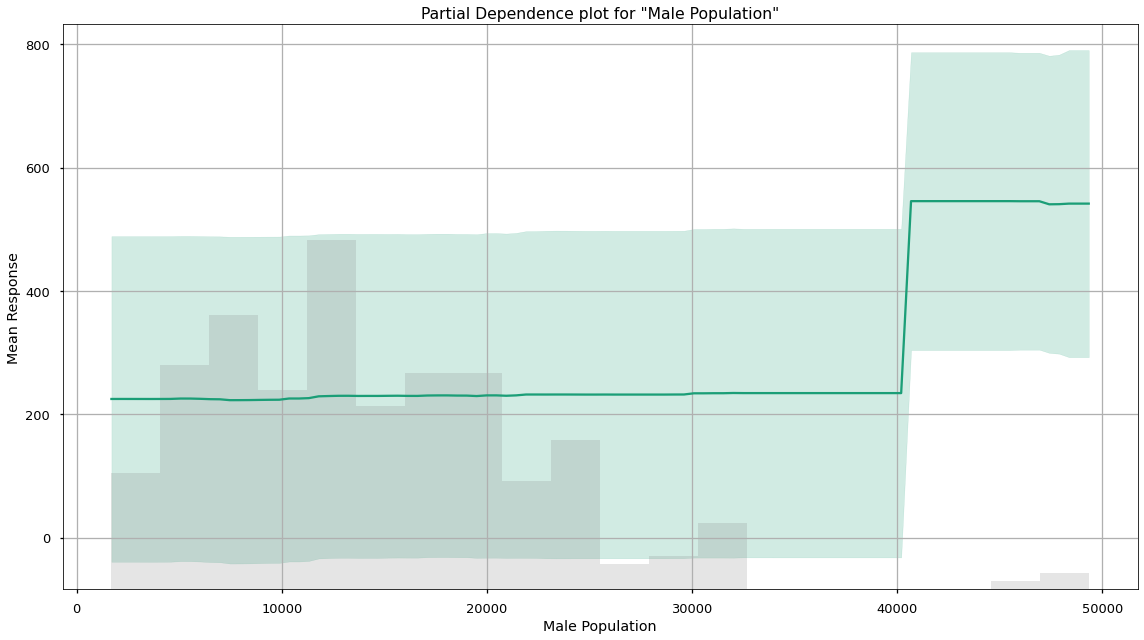

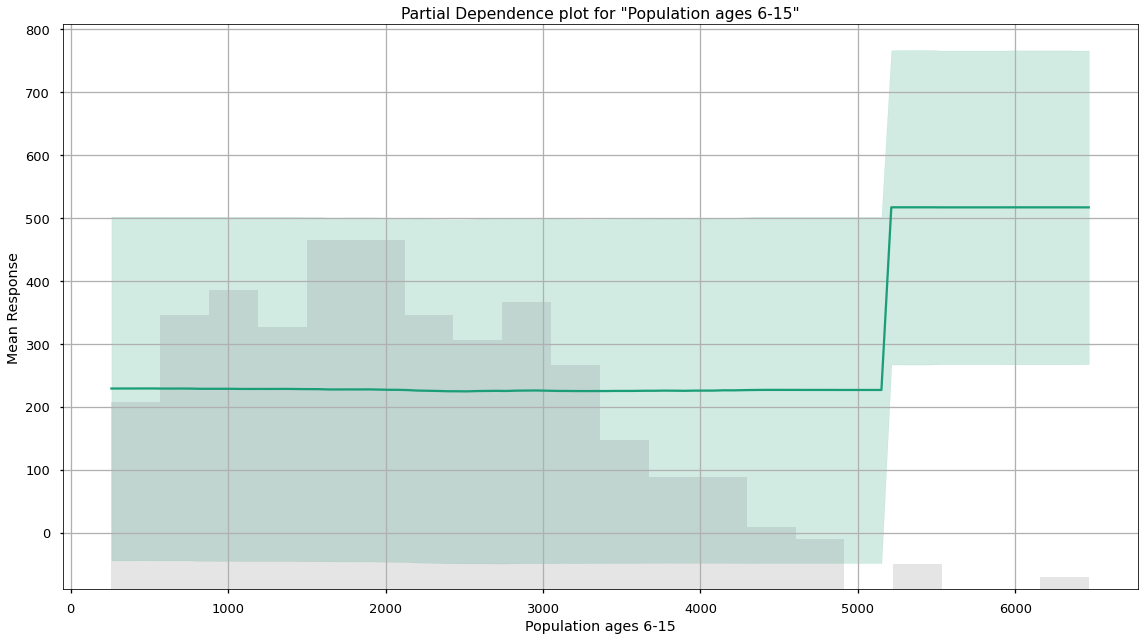

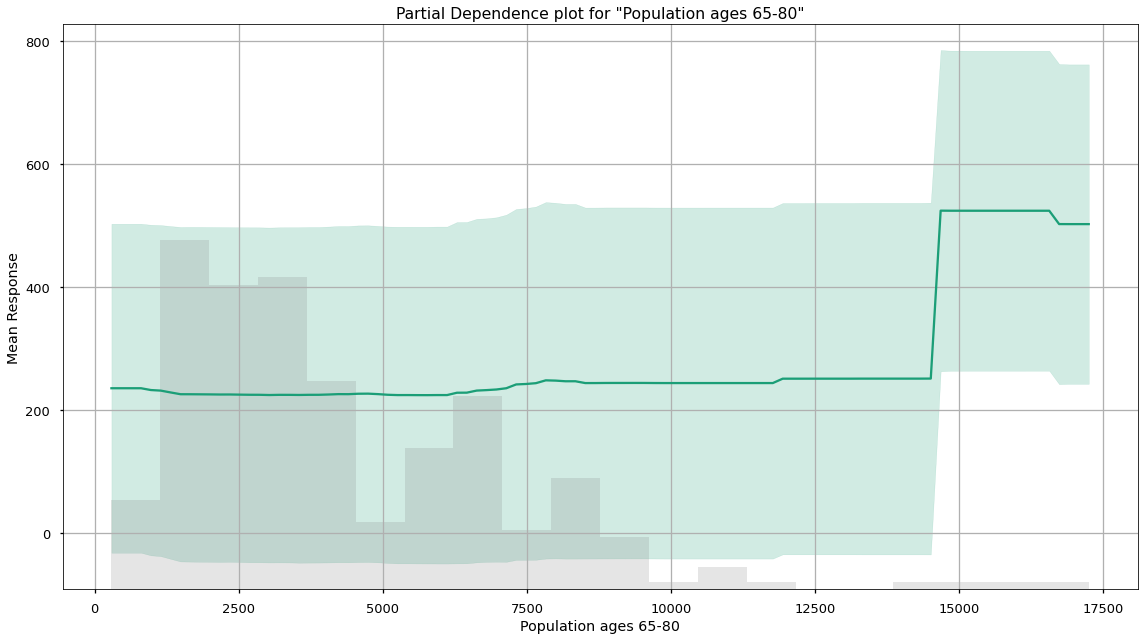

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

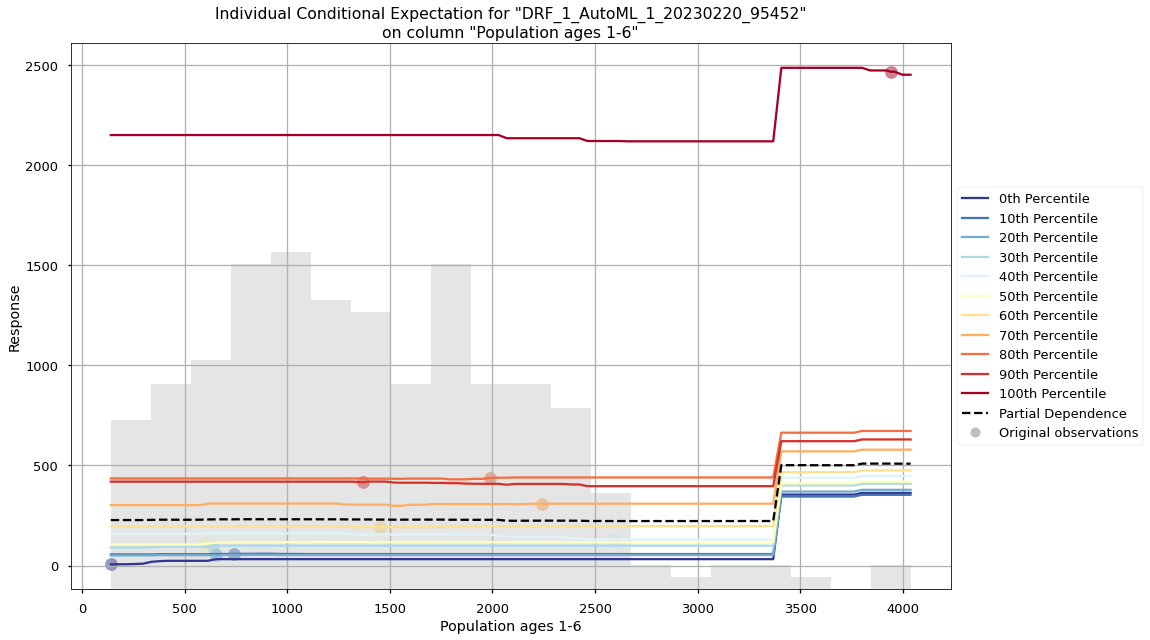

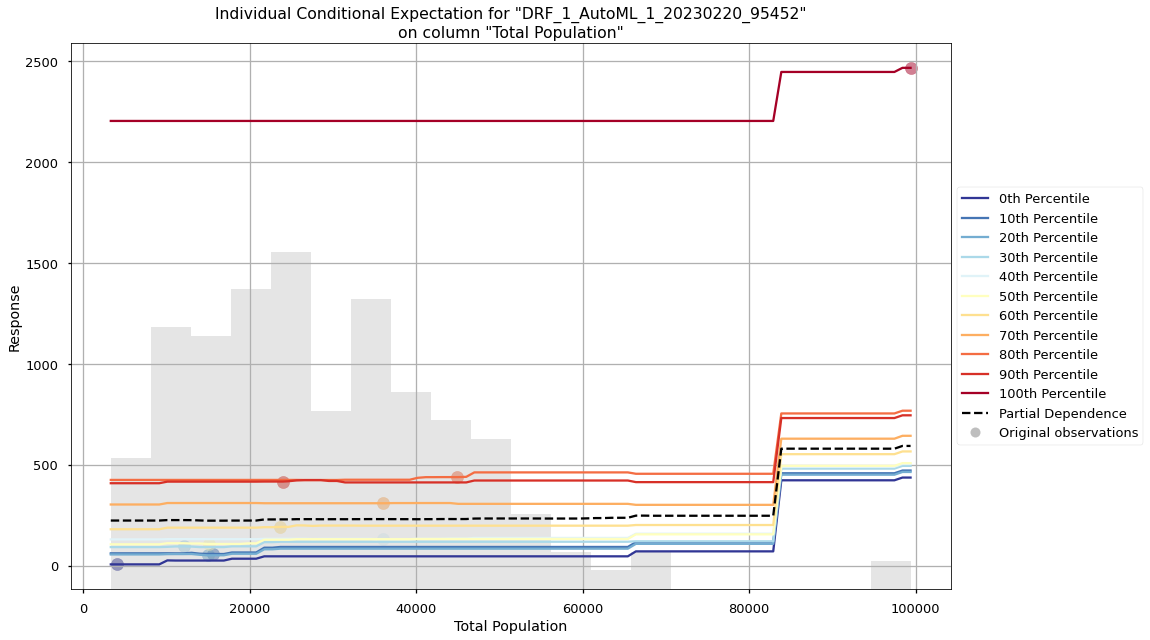

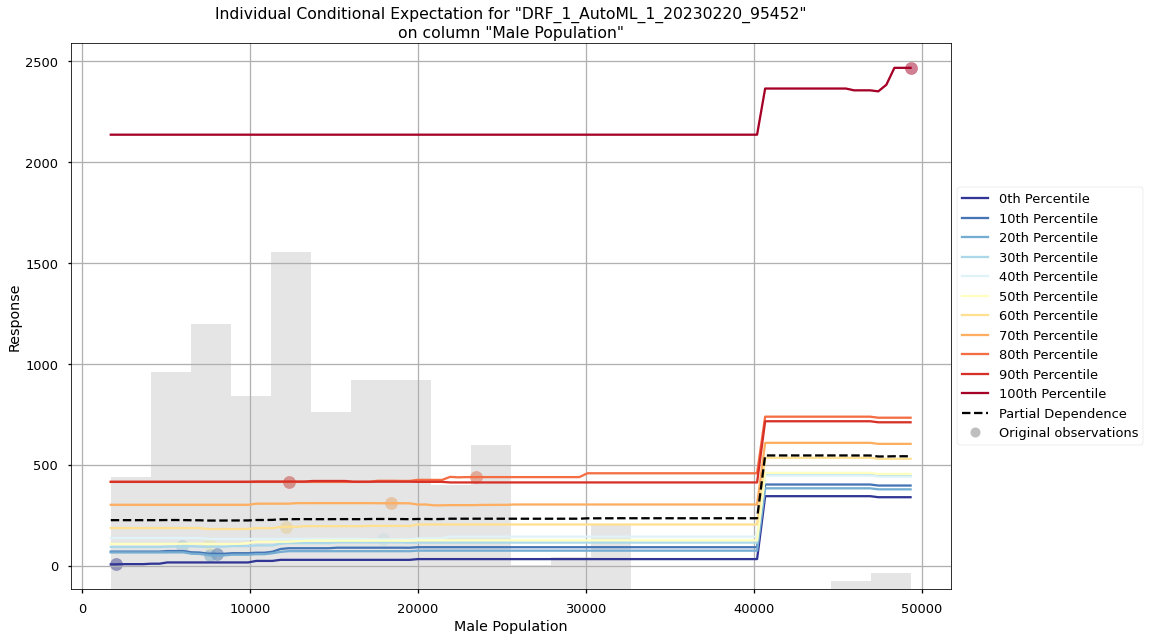

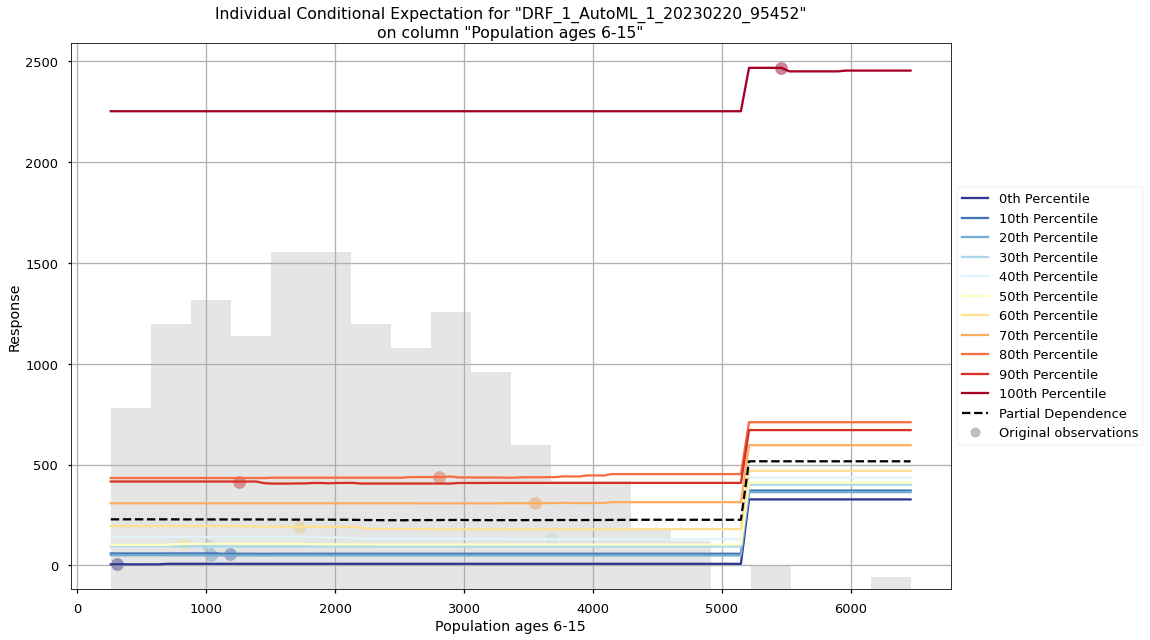

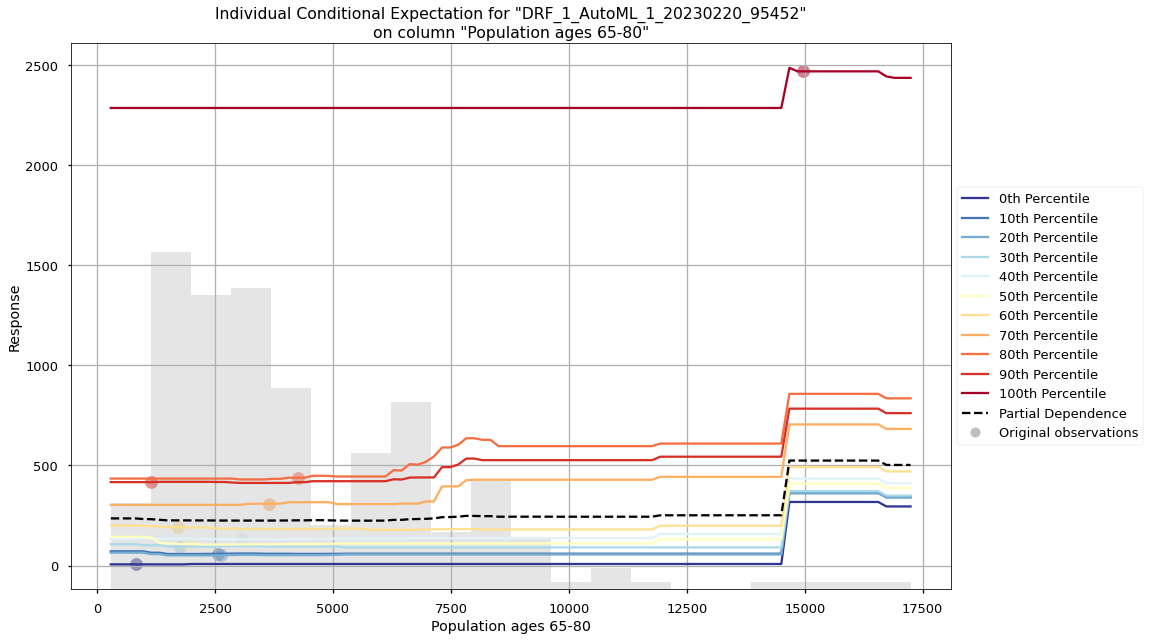

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [2007]:
# Get a specific model by model ID
m = h2o.get_model("DRF_1_AutoML_1_20230220_95452")
h2o.explain(m, test)

In [2008]:
#save model
#h2o.save_model(aml.leader, path = "./crime_model")

In [2009]:
h2o.shutdown()

H2O session _sid_93be closed.


### TreeBasedModels with H2o AutoML

In [2010]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (AdoptOpenJDK)(build 1.8.0_292-b10); OpenJDK 64-Bit Server VM (AdoptOpenJDK)(build 25.292-b10, mixed mode)
  Starting server from /Library/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/ts/yyl2mfyd52n73v7rmhyr_8l40000gn/T/tmpfq6mhwin
  JVM stdout: /var/folders/ts/yyl2mfyd52n73v7rmhyr_8l40000gn/T/tmpfq6mhwin/h2o_manuelfreistein_started_from_python.out
  JVM stderr: /var/folders/ts/yyl2mfyd52n73v7rmhyr_8l40000gn/T/tmpfq6mhwin/h2o_manuelfreistein_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,2 months and 27 days
H2O_cluster_name:,H2O_from_python_manuelfreistein_zbtq8v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2011]:
#Random Forest models allow us to calculate the importance of each feature on the regression result,
#which goes a long way in understanding crime. 
#H2O AutoML showed us that tree models score highly on this particular dataset
#With H2o AutoML we can get the best model for each target variable

#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

In [2012]:
# Create a dataframe to store feature importances
df_feature_importances = pd.DataFrame(index=Straftaten, columns=variables)

Straftaten = df.columns.tolist()[:17]
variables = df.columns.tolist()[17:]

for Straftat in Straftaten:
    # Get data and set target
    dff = df.copy()
    dff_target = dff[Straftat]
    dff = dff[variables].join(dff_target)
    
    # Convert to H2O dataframe
    hf = h2o.H2OFrame(dff)
    train, test = hf.split_frame(ratios=[0.8], seed=1)
    
    # Train the model using H2O AutoML
    aml = H2OAutoML(max_models=5, seed=1, include_algos=["DRF", "GLM", "XGBoost"])
    aml.train(y=Straftat, training_frame=train, leaderboard_frame=test)
    
    # Get variable importance
    varimp = aml.leader.varimp(use_pandas=True)
    
    # Print relevant information
    print("**********************************************************************************")
    print(Straftat)
    print(f"Mean number of {Straftat} crimes: {dff[Straftat].mean()}")
    print(f"Largest number of {Straftat} crimes: {dff[Straftat].max()}")
    print(f"Smallest number of {Straftat} crimes: {dff[Straftat].min()}")
    print(aml.leader.model_performance(test_data=test))
    print(varimp[['variable', 'percentage']])
    print("**********************************************************************************")

    # Update the feature importances dataframe
    for i in varimp['variable']:
        df_feature_importances.at[Straftat, i] = varimp.loc[varimp['variable'] == i, 'percentage'].values[0]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
**********************************************************************************
Straftaten insgesamt
Mean number of Straftaten insgesamt crimes: 3785.063714063714
Largest number of Straftaten insgesamt crimes: 49120
Smallest number of Straftaten insgesamt crimes: 184
ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 664911.3358860976
RMSE: 815.4209562465866
MAE: 500.79903295828814
RMSLE: 0.24002203576404768
Mean Residual Deviance: 664911.3358860976
                               variable  percentage
0                Tobacco retail dealers    0.265638
1                      Total Population    0.240559
2                  Bars, pubs and clubs    0.129691
3         Accidents with minor injuries    0.102519
4            Casinos and betting stores    0.091383
5               Number of

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
**********************************************************************************
Gefährl. und schwere Körperverletzung
Mean number of Gefährl. und schwere Körperverletzung crimes: 80.07536907536908
Largest number of Gefährl. und schwere Körperverletzung crimes: 1068
Smallest number of Gefährl. und schwere Körperverletzung crimes: 0
ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 537.0175950238336
RMSE: 23.17364009006426
MAE: 14.062642498161402
RMSLE: 0.32847644572800605
Mean Residual Deviance: 537.0175950238336
                               variable  percentage
0                  Bars, pubs and clubs    0.365111
1                 Population ages 25-35    0.126493
2                Tobacco retail dealers    0.125955
3            Casinos and betting stores    0.112624
4           

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
**********************************************************************************
Diebstahl an/aus Kfz
Mean number of Diebstahl an/aus Kfz crimes: 242.07303807303808
Largest number of Diebstahl an/aus Kfz crimes: 2492
Smallest number of Diebstahl an/aus Kfz crimes: 7
ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 4042.555306606447
RMSE: 63.58109236720023
MAE: 46.10722894994932
RMSLE: 0.2989095677012626
Mean Residual Deviance: 4042.555306606447
                               variable  percentage
0                      Total Population    0.214450
1                 Good residential area    0.173153
2            Casinos and betting stores    0.109298
3                 Population ages 65-80    0.081884
4                 Population ages 45-55    0.066685
5         Accidents with mino

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
**********************************************************************************
Brandstiftung
Mean number of Brandstiftung crimes: 7.122766122766123
Largest number of Brandstiftung crimes: 76
Smallest number of Brandstiftung crimes: 0
ModelMetricsRegression: drf
** Reported on test data. **

MSE: 16.882855901114144
RMSE: 4.108875259862989
MAE: 2.9770180673977378
RMSLE: 0.5628848846312225
Mean Residual Deviance: 16.882855901114144
                               variable  percentage
0                     Female Population    0.176687
1                       Male Population    0.115405
2                      Total Population    0.081885
3                  Bars, pubs and clubs    0.061110
4                 Population ages 25-35    0.053803
5                 Population ages 65-80    0.047398
6        

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
**********************************************************************************
Kieztaten
Mean number of Kieztaten crimes: 774.7280497280498
Largest number of Kieztaten crimes: 10136
Smallest number of Kieztaten crimes: 23
ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 26834.473902076672
RMSE: 163.81231303560998
MAE: 106.39523490209544
RMSLE: 0.23914505808499362
Mean Residual Deviance: 26834.473902076672
                               variable  percentage
0                Tobacco retail dealers    0.287907
1                  Bars, pubs and clubs    0.160930
2                      Total Population    0.140461
3            Casinos and betting stores    0.057666
4                 Population ages 65-80    0.057247
5                         Liquor stores    0.049039
6              

In [2013]:
df_feature_importances.to_excel('data/H20AutoML_treemodels_importances.xlsx', index=True)

In [2014]:
#df_feature_importances.head()

In [2015]:
h2o.shutdown()

H2O session _sid_89af closed.


## Forecasting with FB Prophet

In [1933]:
#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

In [1944]:
#load data and forecasting model
df_prophet = df.copy()
df_prophet_predictions = pd.DataFrame()
forecaster_Prophet = Prophet()

#predict number of years into the future
horizon = 5

#set up count to keep track of how long there is still to go in the forecasting process
count = 0

#for key_1 in df_prophet.index.get_level_values('key_1').unique():
for key_1 in ['011001']:
        # create a copy of the original DataFrame
        df_prophet = df.copy()
        # extract data for a single Bezirksregion
        df_prophet_single = df_prophet[df_prophet.index.get_level_values('key_1') == key_1]
        Bzkr = df_prophet_single.index.get_level_values('Bezirksregion')[0]
        # set the index to a DatetimeIndex and resample the data to yearly frequency
        df_prophet_single = df_prophet_single.set_index(pd.DatetimeIndex(["2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]), drop = True)
        df_prophet_single = df_prophet_single.resample(rule = "AS").mean()
        # fit the Prophet model to the selected data
        forecaster_Prophet.fit(df_prophet_single)
        # create a forecasting horizon
        fh_Prophet = ForecastingHorizon(pd.date_range('2021-01-01 00:00:00', periods = horizon, freq = "AS"), is_relative = False)
        # use the Prophet model to predict values for the forecasting horizon
        Prophet_prediction = forecaster_Prophet.predict(fh_Prophet)
        # combine the selected data and the predicted values into a single DataFrame
        df_forecast = pd.concat([df_prophet_single, Prophet_prediction])
        # add key_1, Bezirksregion, and year information to the DataFrame
        df_forecast['year'] = list(range(2012,2026))
        df_forecast['key_1'] = key_1
        df_forecast['Bezirksregion'] = Bzkr
        df_forecast = df_forecast.set_index(['key_1', 'Bezirksregion', 'year'])
        # add the forecasted data to the DataFrame containing all forecast results
        df_prophet_predictions = pd.concat([df_prophet_predictions, df_forecast])
        # ensure that all values in the DataFrame are non-negative integers
        df_prophet_predictions = df_prophet_predictions.applymap(lambda x : int(x) if x > 0 else 0)
        # print progress information
        print(str(count)+"/142")
        count = count+1

In [1945]:
#df_prophet_predictions.head()

In [1946]:
df_prophet_predictions.to_excel('Data/df_prophet_predictions.xlsx', index=True)

In [1947]:
#Testing fbprophet predictions on the 2021 Kriminalstatistik dataset

In [1948]:
# Load Kriminalstatistik predictions for 2021
df_Kriminalstatistik_2021 = Kriminalstatistik_Fallzahlen_2012_2021[9].copy()
df_Kriminalstatistik_2021 = add_zeros_key_1(df_Kriminalstatistik_2021)
df_Kriminalstatistik_2021 = df_Kriminalstatistik_2021.drop('index', axis=1)

In [1949]:
# Load df_prophet predictions
df_prophet_predictions = pd.read_excel("Data/df_prophet_predictions.xlsx", index_col=[0,1,2])
df_prophet_predictions = add_zeros_key_1(df_prophet_predictions)
#extract predictions for 2021
df_prophet_predictions_2021 = df_prophet_predictions[df_prophet_predictions.index.get_level_values("year") == 2021]
#remove predictions not related to crime statistics
df_prophet_predictions_2021 = df_prophet_predictions_2021.iloc[:,[*range(0,17)]]

In [1950]:
#calculate errors, mean absolute error and mean squared error
errors = df_Kriminalstatistik_2021.subtract(df_prophet_predictions_2021, fill_value=0)
mae_2021 = errors.abs().mean()
mse_2021 = errors.apply(lambda x: x**2).mean()

In [1951]:
mae_2021

Straftaten insgesamt                                     685.062937
Raub                                                       9.272727
Straßenraub, Handtaschenraub                               5.909091
Körperverletzungen insgesamt                              65.083916
Gefährl. und schwere Körperverletzung                     18.419580
Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung     24.811189
Diebstahl insgesamt                                      393.741259
Diebstahl von Kraftwagen                                  16.461538
Diebstahl an/aus Kfz                                      55.888112
Fahrraddiebstahl                                          65.139860
Wohnraumeinbruch                                          19.279720
Branddelikte insgesamt                                     8.041958
Brandstiftung                                              3.573427
Sachbeschädigung insgesamt                                54.608392
Sachbeschädigung durch Graffiti                 

In [1952]:
mse_2021

Straftaten insgesamt                                     3.245482e+06
Raub                                                     2.370210e+02
Straßenraub, Handtaschenraub                             7.596503e+01
Körperverletzungen insgesamt                             2.048513e+04
Gefährl. und schwere Körperverletzung                    1.203846e+03
Freiheitsberaubung, Nötigung, Bedrohung, Nachstellung    1.620853e+03
Diebstahl insgesamt                                      9.804567e+05
Diebstahl von Kraftwagen                                 6.536084e+02
Diebstahl an/aus Kfz                                     9.514336e+03
Fahrraddiebstahl                                         2.002522e+04
Wohnraumeinbruch                                         1.029825e+03
Branddelikte insgesamt                                   1.298042e+02
Brandstiftung                                            2.807692e+01
Sachbeschädigung insgesamt                               1.185924e+04
Sachbeschädigung dur

# Analysis and Visualizations

In [2016]:
#Function to add zeros from the beginning of key_1. They are removed automatically while loading from excel file
def add_zeros_key_1(df):
    df = df.reset_index(inplace=False)
    df["key_1"] = df["key_1"].apply(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
    #reset the multi index
    df.set_index(['key_1', 'year', 'Bezirksregion'], inplace=True)
    return df

In [2017]:
def create_variables_df(df, df_type='merged'):
    variables = df.columns.tolist()[17:]
    if df_type == 'by_area':
        variables.remove("area")
    if df_type == 'by_population':
        variables.remove("E insgesamt")
    df = df[variables]
    return df

## Principal Component Analysis

In [2018]:
#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

#PCA is more effective if we choose a single year
df = df.loc[(df.index.get_level_values('year') == 2020)]

#create dataframe of variables
#optional: pass 'by_area' or 'by_population' as third parameter if if working with df_by_area or df_by_population dataframes
#df_pca = create_variables_df(df)

In [2019]:
#scale and fit data for pca

scaled_data = StandardScaler().fit_transform(df_pca)
pca = PCA(n_components = 2)
scores = pca.fit_transform(scaled_data)

#loadings for the PCs
x_loading = pca.components_[0]
y_loading = pca.components_[1]

#scores of the PCs
x_score = scores[:,0]
y_score = scores[:,1]

In [2020]:
#Calculate the cumulative explained variance of the principal components
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
print("Cumulative explained variance of Principal Components: " +str(round(cum_sum_eigenvalues[-1:][0]*100))+ "%")

Cumulative explained variance of Principal Components: 66%


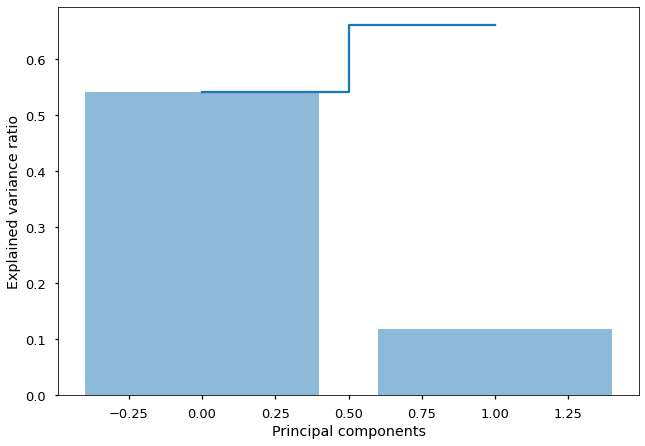

In [2021]:
#plot the cumulative explained variance of the principal components 
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

Text(0, 0.5, 'Second Principal Component')

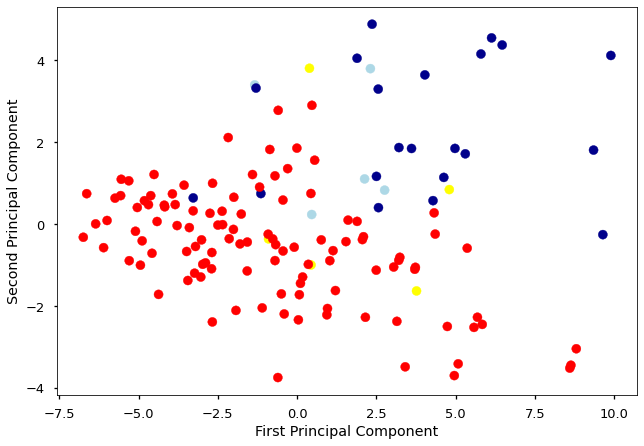

In [2022]:
#plot the observations (Bezirksregionen) in PC plot

#set colors to reflect quartiles of selected Straftat
Target_Straftat = "Straftaten insgesamt"
scaled_target = StandardScaler().fit_transform(pd.DataFrame(df[Target_Straftat])).reshape(-1)

colors = pd.cut(scaled_target,
    bins=[np.NINF, 0.25, .5, .75, np.inf],
    labels=['red', 'yellow', 'lightblue', 'darkblue'],
    right=False)

plt.scatter(x_score, y_score, c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

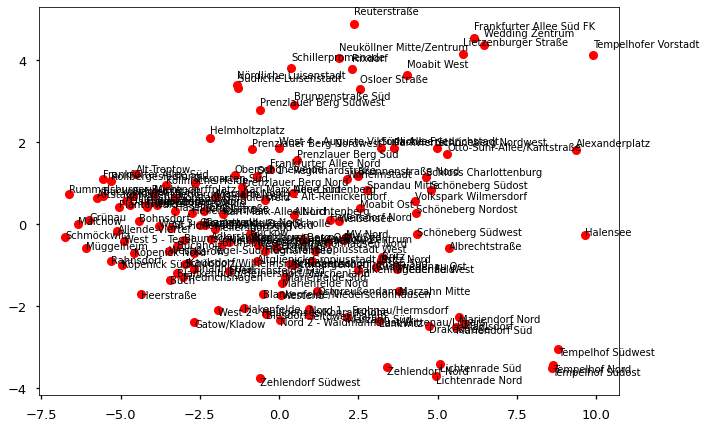

In [2023]:
#plot names of observations (Bezirksregionen) on PC plot
for i in range(len(x_score)):
    plt.plot(x_score[i], y_score[i], 'ro')
    plt.text(x_score[i], y_score[i]*1.05, list(df_pca.index.get_level_values("Bezirksregion"))[i], color='black')
plt.show()

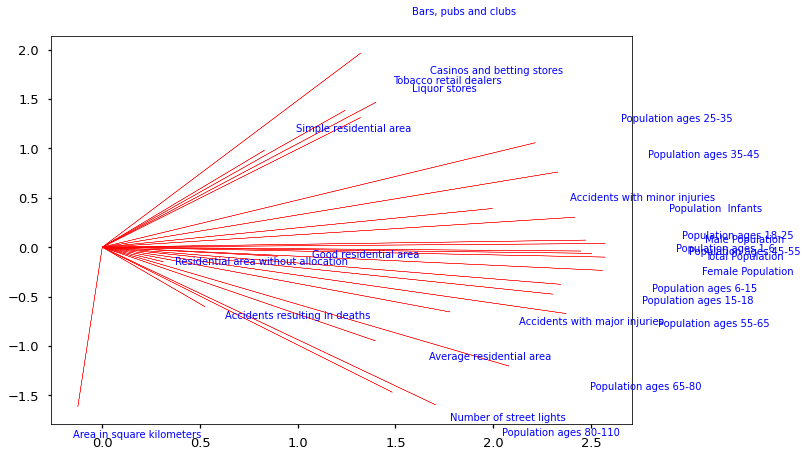

In [2024]:
#plot loadings of variables on PC plot
for i in range(len(x_loading)):
    plt.arrow(0, 0, x_loading[i]*x_score.max(),
              y_loading[i]*y_score.max(),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(x_loading[i]*x_score.max()*1.2, y_loading[i]*y_score.max()*1.2,
             list(df_pca.columns.values)[i], color='b')
plt.show()

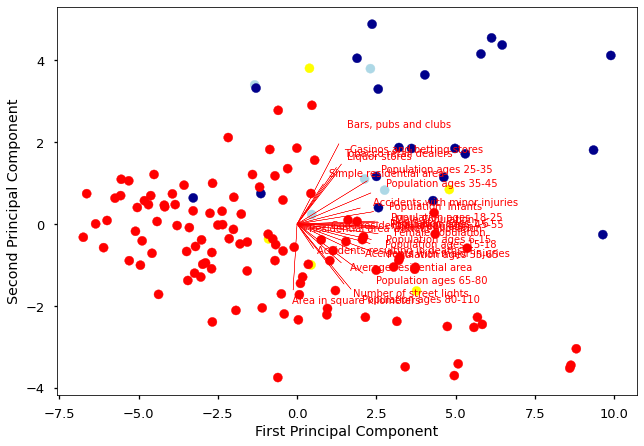

In [2025]:
#biplot of chose PCs 

#set colors to reflect quartiles of selected Straftat
Target_Straftat = "Straftaten insgesamt"
scaled_target = StandardScaler().fit_transform(pd.DataFrame(df[Target_Straftat])).reshape(-1)

colors = pd.cut(
    scaled_target,
    bins=[np.NINF, 0.25, .5, .75, np.inf],
    labels=['red', 'yellow', 'lightblue', 'darkblue'],
    right=False)

plt.scatter(x_score, y_score, c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

for i in range(len(x_loading)):
    plt.arrow(0, 0, x_loading[i]*x_score.max(), y_loading[i]*y_score.max(),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(x_loading[i]*x_score.max()*1.2, y_loading[i]*y_score.max()*1.2,
             list(df_pca.columns.values)[i], color='r')

## Maps

In [2026]:
#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
#df = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1(df)

#importing and cleaning Berlin Bezirksregionen spatial data
Bezirksregionen_spatial = gpd.read_file("./Data/LOR/lor_shp_2019/Bezirksregion_EPSG_25833.shp")
Bezirksregionen_spatial.crs = "epsg:25833"
Bezirksregionen_spatial = Bezirksregionen_spatial.to_crs(epsg=4326)
Bezirksregionen_spatial = Bezirksregionen_spatial.rename(columns={'SCHLUESSEL': 'key_2'})
Bezirksregionen_spatial = Bezirksregionen_spatial[['key_2', 'geometry']]

#importing and cleaning df_keys
df_keys = pd.read_excel("Data/df_keys.xlsx", index_col = [0])
for key in ["key_1", "key_2"]:
    df_keys[key] = df_keys[key].apply(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#merging spatial data with df_keys on key_2 and df on key_1
Bezirksregionen_spatial = pd.merge(Bezirksregionen_spatial, df_keys, on = ['key_2', 'key_2'])
df_spatial = Bezirksregionen_spatial.dissolve(by='key_1')
df_spatial.reset_index(inplace=True)
df_spatial = pd.merge(df_spatial, df, on = ['key_1', 'key_1'])

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



/Library/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



<AxesSubplot:>

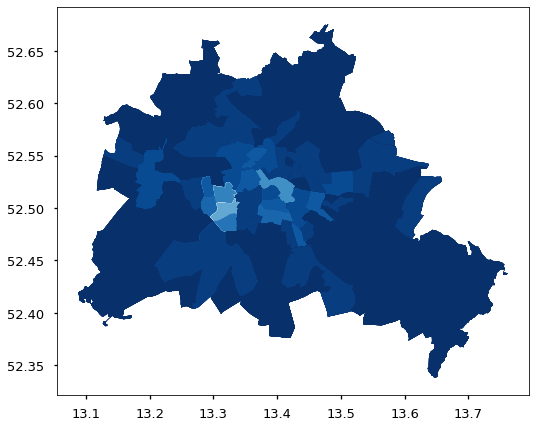

In [2027]:
#adding color to map according to specified columns
target = 'Straftaten insgesamt'
df_spatial.plot(column=target, scheme='equal_interval', k=20, cmap=plt.cm.Blues_r, alpha=1)

# Dashboard

In [2028]:
#Function to add zeros from the beginning of key_1. They are removed automatically while loading from excel file
def add_zeros_key_1_no_index(df):
    df = df.reset_index(inplace=False)
    df["key_1"] = df["key_1"].apply(lambda x: "0"+str(x) if len(str(x))<6 else str(x))
    return df

In [2029]:
#Loading all data needed for the dashboard

#load data from saved excel files (f.ex. data scaled by population) with index
df = pd.read_excel("Data/df_merged.xlsx", index_col = [0,1,2])
df_per_area = pd.read_excel("Data/df_by_area.xlsx", index_col = [0,1,2])
df_per_pop = pd.read_excel("Data/df_by_population.xlsx", index_col = [0,1,2])

#zeros are removed from the beginning key_1 when loading from excel file. They needed to be added again.
df = add_zeros_key_1_no_index(df)
df_per_area = add_zeros_key_1_no_index(df_per_area)
df_per_pop = add_zeros_key_1_no_index(df_per_pop)

#importing and cleaning Berlin Bezirksregionen spatial data
Bezirksregionen_spatial = gpd.read_file("./Data/LOR/lor_shp_2019/Bezirksregion_EPSG_25833.shp")
Bezirksregionen_spatial.crs = "epsg:25833"
Bezirksregionen_spatial = Bezirksregionen_spatial.to_crs(epsg=4326)
Bezirksregionen_spatial = Bezirksregionen_spatial.rename(columns={'SCHLUESSEL': 'key_2'})
Bezirksregionen_spatial = Bezirksregionen_spatial[['key_2', 'geometry']]

#importing and cleaning df_keys
df_keys = pd.read_excel("Data/df_keys.xlsx", index_col = [0])
for key in ["key_1", "key_2"]:
    df_keys[key] = df_keys[key].apply(lambda x: "0"+str(x) if len(str(x))<6 else str(x))

#merging spatial data with df_keys on key_2
Bezirksregionen_spatial = pd.merge(Bezirksregionen_spatial, df_keys, on = ['key_2', 'key_2'])
df_spatial = Bezirksregionen_spatial.dissolve(by='key_1')
df_spatial.reset_index(inplace=True)

#simplify geometry to run dashboard choropleth map faster
df_spatial["geometry"] = df_spatial["geometry"].simplify(1)

#merging spatial data with df on key_1
df_spatial_temp = df_spatial.copy()
df_spatial = pd.merge(df_spatial, df, on = ['key_1', 'key_1'])
df_spatial_per_pop = pd.merge(df_spatial_temp, df_per_pop, on = ['key_1', 'key_1'])
df_spatial_per_area = pd.merge(df_spatial_temp, df_per_area, on = ['key_1', 'key_1'])

#load prediction data from saved excel files with index
df_pred_prophet = pd.read_excel("Data/df_prophet_predictions.xlsx", index_col = [0,1,2])

#load Random Forest algorithm's feature_importances
#df_RF_feature_importances = pd.read_excel("Data/df_RF_feature_importances.xlsx", index_col = [0])
df_RF_feature_importances = pd.read_excel("Data/H20AutoML_treemodels_importances.xlsx", index_col = [0])

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:805: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/Library/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning:

__len__ for mult

In [2030]:
#Create Dashboard with Plotly Express and Dash Bootstrap Components

# Make copies of the original dataframes
dff = df_spatial.copy()
dff_per_pop = df_spatial_per_pop.copy()
dff_per_area = df_spatial_per_area.copy()
dff_predictions = df_pred_prophet.copy()

# Define a list of names for the different dataframes
df_names = ["Total", "Per capita", "Per square kilometer"]

# Get a list of dictionaries of the "Bezirksregion" names
Bezirksregionen_names = [{"label": region, "value": region} for region in dff_predictions.index.get_level_values('Bezirksregion').unique()]

# Define a list of variables to be used in the dropdown menus, excluding certain variables
excluded_variables = ["Total Population", "Area in square kilometers", "key_1", "geometry", "key_2", "year", "Bezirksregion"]
variable_names = [{"label": var, "value": var} for var in dff.columns if var not in excluded_variables]

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.LUX])

title = dcc.Markdown(children = "Berlin Crime Dashboard", style={'color': 'white', 'text-align': 'center'})

title_fig1 = dcc.Markdown(children = "Top 5 types of crimes committed in each district", style={'color': 'white', 'text-align': 'center'})
title_fig2 = dcc.Markdown(children = "Districts with highest crime rates for each type of crime", style={'color': 'white', 'text-align': 'center'})
title_fig3 = dcc.Markdown(children = "Crime rates and prediction 2012-2025 for each district", style={'color': 'white', 'text-align': 'center'})
title_fig4 = dcc.Markdown(children = "H2O AutoML best tree model's variable importance for each type of crime", style={'color': 'white', 'text-align': 'center'})
title_fig5 = dcc.Markdown(children = "Crime Map Berlin", style={'color': 'white', 'text-align': 'center'})


dropdown_region_top = dcc.Dropdown(id="slct_dropdown_region_top",
                                 searchable=True,
                                 options=Bezirksregionen_names,
                                 multi=False,
                                 value="Parkviertel",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

pie_top_region = dcc.Graph(id='fig_pie_top_region',style={'display': 'inline-block'})

slider_top_region = dcc.Slider(min=dff['year'].min(),
                        max=dff['year'].max(),
                        step=None,
                        value=dff['year'].max(),
                        marks={str(year): str(year) for year in dff['year'].unique()},
                        id='slct_slider_top_region')

dropdown_type_top = dcc.Dropdown(id="slct_dropdown_type_top",
                                 searchable=True,                                 
                                 options=variable_names[:17],
                                 multi=False,
                                 value="Straftaten insgesamt",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

barchart_top_type = dcc.Graph(id='fig_barchart_top_type',style={'display': 'inline-block'})

slider_top_type = dcc.Slider(min=dff['year'].min(),
                        max=dff['year'].max(),
                        step=None,
                        value=dff['year'].max(),
                        marks={str(year): str(year) for year in dff['year'].unique()},
                        id='slct_slider_top_type')


dropdown_region_pred = dcc.Dropdown(id="slct_dropdown_region_pred",
                                    searchable=True,
                                    options=Bezirksregionen_names,
                                    multi=False,
                                    value="Alexanderplatz",
                                    style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black',
                                        'display': 'inline-block'},)

dropdown_type_pred = dcc.Dropdown(id="slct_dropdown_type_pred",
                                  searchable=True,
                                  options=variable_names[:17],
                                  multi=False,
                                  value="Raub",
                                  style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

graph_barchart_prediction = dcc.Graph(id='fig_barchart_prediction',style={'display': 'inline-block'})

dropdown_type_RF_importance = dcc.Dropdown(id="slct_dropdown_type_RF_importance",
                                  searchable=True,
                                  options=variable_names[:17],
                                  multi=False,
                                  value="Sachbeschädigung insgesamt",
                                  style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black'})

pie_RF_importance = dcc.Graph(id='fig_pie_RF_importance',style={'display': 'inline-block'})

dropdown_df_map = dcc.Dropdown(id="slct_dropdown_df_map",
                                 searchable=True,
                                 options=df_names,
                                 multi=False,
                                 value="Per square kilometer",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black',
                                        'justify-content': 'center'})

dropdown_type_map = dcc.Dropdown(id="slct_dropdown_type_map",
                                 searchable=True,
                                 options=variable_names,
                                 multi=False,
                                 value="Sachbeschädigung durch Graffiti",
                                 style={'width': "100%",
                                       'backgroundColor': 'black', 
                                        'color': 'black',
                                        'justify-content': 'center'})
            
graph_map = dcc.Graph(id='fig_map', figure={}, style={})

slider_map = dcc.Slider(min=dff['year'].min(),
                        max=dff['year'].max(),
                        step=None,
                        value=dff['year'].max(),
                        marks={str(year): str(year) for year in dff['year'].unique()},
                        id='slct_slider_map')


In [2031]:
app.layout = html.Div(dbc.Card(dbc.CardBody([dbc.Row([title]), 
                                             html.Br(),
                                             dbc.Row([
                                                 dbc.Col([title_fig1], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([title_fig2], width=5),                                             
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([dropdown_region_top], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([dropdown_type_top], width=5),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([pie_top_region], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([barchart_top_type], width = 5),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([slider_top_region], width=4),
                                                 dbc.Col([], width = 2),
                                                 dbc.Col([slider_top_type], width=4),
                                             ]),
                                             html.Br(),
                                             dbc.Row([
                                                 dbc.Col([title_fig3], width = 5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([title_fig4], width=5),                                             
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([dropdown_region_pred], width=5),
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([dropdown_type_RF_importance], width = 5),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([dropdown_type_pred], width = 5),
                                                 dbc.Col([], width = 6),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([pie_RF_importance], width = 5),                                                
                                                 dbc.Col([], width = 1),
                                                 dbc.Col([graph_barchart_prediction], width = 5),
                                             ]),
                                             html.Br(),
                                             dbc.Row([
                                                 dbc.Col([], width = 2),
                                                 dbc.Col([title_fig5], width = 7),
                                                 dbc.Col([], width=2),                                             
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([], width = 3),
                                                 dbc.Col([dropdown_df_map], width = 5),
                                                 dbc.Col([], width = 3),
                                             ]),
                                             dbc.Row([
                                                 dbc.Col([], width = 3),
                                                 dbc.Col([dropdown_type_map], width = 5),
                                                 dbc.Col([], width = 3),
                                             ]),
                                             dbc.Row([graph_map]),
                                             dbc.Row([
                                                 dbc.Col([], width = 2),
                                                 dbc.Col([slider_map], width = 7)]),
                                                 dbc.Col([], width = 2),
                                             ]), color = 'black',),)


In [2032]:
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output('fig_pie_top_region', 'figure'),
            Output('fig_barchart_top_type', 'figure'),
            Output('fig_pie_RF_importance', 'figure'),
            Output('fig_barchart_prediction', 'figure'),
            Output('fig_map', 'figure')],
    
    [Input('slct_dropdown_region_top', 'value'), Input('slct_slider_top_region', 'value'),
         Input('slct_dropdown_type_top', 'value'), Input('slct_slider_top_type', 'value'),
         Input('slct_dropdown_region_pred', 'value'), Input('slct_dropdown_type_pred', 'value'), Input('slct_dropdown_type_RF_importance', 'value'),
         Input('slct_dropdown_df_map', 'value'), Input('slct_dropdown_type_map', 'value'), Input('slct_slider_map', 'value')]
)
def update_graph(slct_dropdown_region_top, slct_slider_top_region,
                 slct_dropdown_type_top, slct_slider_top_type,
                 slct_dropdown_region_pred, slct_dropdown_type_pred, slct_dropdown_type_RF_importance,
                 slct_dropdown_df_map, slct_dropdown_type_map, slct_slider_map):
    
    # Make a copy of the dataframes
    dff = df_spatial.copy()
    dff_per_pop = df_spatial_per_pop.copy()
    dff_per_area = df_spatial_per_area.copy()
    dff_predictions = df_pred_prophet.copy()
    dff_RF_feature_imp = df_RF_feature_importances.copy().T

    #Select data for top region pie chart
    dff_top_region_columns = dff[dff["year"] == slct_slider_top_region][dff["Bezirksregion"] == slct_dropdown_region_top].columns.values.tolist()[6:22]
    dff_top_region = dff[dff["year"] == slct_slider_top_region][dff["Bezirksregion"] == slct_dropdown_region_top].iloc[:,6:22].iloc[:1].values.flatten().tolist()
    srs = pd.Series(dff_top_region)
    top_idx = srs.nlargest(5).index.values.tolist()
    remaining_idx = srs.nsmallest(11).index.values.tolist()
    remaining_sum = sum(srs[remaining_idx])
    values_pie = srs[top_idx].tolist()+[remaining_sum]
    names_pie = [dff_top_region_columns[i] for i in top_idx]+['Remaining']
    
    # Select data for the feature importance pie chart
    dff_RF_feature_imp = dff_RF_feature_imp[slct_dropdown_type_RF_importance]
    top_features = dff_RF_feature_imp.nlargest(5)
    top_features["remaining"] = 1-sum(top_features)

    # Select data for top type bar chart
    dff_top_type = dff[dff["year"] == slct_slider_top_type].nlargest(10, slct_dropdown_type_top)

    # Select data for prediction bar chart
    dff_pred_region = dff_predictions[dff_predictions.index.get_level_values("Bezirksregion") == slct_dropdown_region_pred]

    # Select data for choropleth map
    dff_map_year = dff[dff["year"] == slct_slider_map][slct_dropdown_type_map]  
    dff_per_pop_map_year = dff_per_pop[dff_per_pop["year"] == slct_slider_map][slct_dropdown_type_map] 
    dff_per_area_map_year = dff_per_area[dff_per_area["year"] == slct_slider_map][slct_dropdown_type_map] 
    dfs = {"Total": dff_map_year, "Per capita": dff_per_pop_map_year, "Per square kilometer": dff_per_area_map_year}

    #top region pie chart
    fig1 = px.pie(values=values_pie, names=names_pie, color_discrete_sequence=px.colors.sequential.RdBu)
    fig1.update_layout(autosize=False, width=600, height=470,)
    fig1.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig1.update_traces(textposition='inside', textinfo='percent')
    fig1.update_traces(pull=[0, 0, 0, 0, 0, 0.1])

    #highest crime rate bar chart
    fig2 = px.bar(dff_top_type,
                  x = dff_top_type["Bezirksregion"],
                  y = slct_dropdown_type_top,)
    fig2.update_traces(hovertemplate = "District: %{x} <br>Value: %{y}")
    fig2.update_xaxes(title_text = '')
    fig2.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig2.update_layout(autosize=False, width=600, height=470,)
    fig2.update_traces(marker_color='darkgreen')

    #predictions bar chart
    fig3 = px.bar(dff_pred_region,
                 x = dff_pred_region.index.get_level_values('year').unique(),
                 y = slct_dropdown_type_pred,
                 color = (["actual"]*9)+(['forecast']*5),
                 color_discrete_map={
                     'actual': 'darkgreen',
                     'forecast': 'darkred'},
                 labels={'x': 'Year'})
    fig3.update_traces(hovertemplate = "Year: %{x} <br>Value: %{y}")
    fig3.update_layout(showlegend=True)
    fig3.update_layout(template='plotly_dark',
                       plot_bgcolor= 'rgba(0, 0, 0, 0)',
                       paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig3.update_layout(autosize=False, width=600, height=400,)
    
    #feature importance pie chart
    fig4 = px.pie(values=top_features, names=top_features.index, color_discrete_sequence=px.colors.sequential.RdBu)
    fig4.update_layout(autosize=False, width=600, height=470,)
    fig4.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
    fig4.update_traces(textposition='inside', textinfo='percent')
    fig4.update_traces(pull=[0, 0, 0, 0, 0, 0.1])
    
    #choropleth map
    fig5 = px.choropleth(dfs[slct_dropdown_df_map],
                        geojson=dff.geometry,
                        locations = dfs[slct_dropdown_df_map].index,
                        color = slct_dropdown_type_map,
                        height=500,
                        color_continuous_scale="Hot",
                        hover_name = dff[dff['year'] == slct_slider_map]["Bezirksregion"])  
    
    fig5.update_geos(fitbounds="locations",
                    visible=True)
    fig5.update_layout(template='plotly_dark',
                        plot_bgcolor= 'rgba(0, 0, 0, 0)',
                        paper_bgcolor= 'rgba(0, 0, 0, 0)',)
        
    return fig1, fig2, fig3, fig4, fig5

In [2033]:
# access dashboard at: http://127.0.0.1:8043/

if __name__ == '__main__':
    app.run_server(mode="jupyterlab", host="127.0.0.1", debug=True, port=8043)

In [2034]:
import os
os.path.abspath(os.getcwd())

'/Users/manuelfreistein/Desktop/Urban tech project'

# __Sources__


-Einwohnerregisterstatistik: GovData 
https://www.govdata.de/daten/-/details/einwohnerinnen-und-einwohner-in-berlin-in-lor-planungsraumen-am-31-12-2020

-Kriminalitätsatlas: GovData
https://www.govdata.de/suchen/-/details/kriminalitatsatlas-berlin

-Berlin spatial data: Daten Open Berlin
https://daten.berlin.de/datensaetze/geometrien-der-lor-bezirksregionen-berlins-stand-072012

-Öffentliche Beleuchtung: FIS Broker
https://fbinter.stadt-berlin.de/fb/?loginkey=alphaDataStart&alphaDataId=s_oeffbeleucht@senstadt

-Spaetis Bars Wettshops: Amt für Statistik Berlin Brandenburg
https://www.statistik-berlin-brandenburg.de/

-Straßenverkehrsunfälle: Daten Open Berlin
https://daten.berlin.de/datensaetze/stra%C3%9Fenverkehrsunf%C3%A4lle-nach-unfallort-berlin-2021

-Wohnlage: Daten Open Berlin
https://daten.berlin.de/datensaetze/einwohnerinnen-und-einwohner-nach-wohnlagen-den-lor-planungsr%C3%A4umen-am-31122012